In [10]:
import scipy.sparse as sp
import pandas as pd
import scanpy as sc
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
from mygene import MyGeneInfo

In [11]:
import numpy as np
np.NAN = np.nan

In [12]:
import omnipath as op

In [13]:
from markov_clustering import run_mcl, get_clusters

In [14]:
from matplotlib.colors import rgb2hex

In [15]:
import leidenalg

In [16]:
from omnipath.interactions import OmniPath

# 0 Setup & ath

In [17]:
BASE = Path("/storage/users/job37yv/Projects/Franziska_faber")
EM_DIR = BASE / "analysis" / "expr_mean"       # where expr_mean.pkl lives
OUT    = BASE / "analysis" / "Networks"        # outputs
OUT.mkdir(parents=True, exist_ok=True)

# inputs
EXPR_MEAN = EM_DIR / "expr_mean.pkl"           # log2-transformed, UniProt-filtered
assert EXPR_MEAN.exists(), f"Missing {EXPR_MEAN}"

# conditions to analyze (columns in expr_mean)
COND_COLS = ["Bt", "Cd", "Co", "Mock"]


# 1 Load expression (expr_mean) and build condition-wise node tables

In [18]:
# --- Load expr_mean and shape into condition-wise node tables ---
expr_mean = pd.read_pickle(EXPR_MEAN)
# keep only columns we need + annotations
need_cols = [c for c in COND_COLS if c in expr_mean.columns] + ["UniProtID","gene_symbol"]
expr_mean = expr_mean[need_cols].dropna(subset=["UniProtID"]).copy()

# normalize UniProt into strings (just in case)
expr_mean["UniProtID"] = expr_mean["UniProtID"].astype(str)

# condition-wise nodes (UniProt + expr_log2)
nodes_by_cond = {
    cond: (expr_mean[["UniProtID", cond]]
           .rename(columns={"UniProtID":"uniprot", cond:"expr_log2"}))
    for cond in COND_COLS if cond in expr_mean.columns
}

# optional deduplication: if same UniProt appears multiple times, keep max expr
for cond in list(nodes_by_cond):
    df = nodes_by_cond[cond]
    nodes_by_cond[cond] = (df.groupby("uniprot", as_index=False)["expr_log2"]
                           .max()
                           .sort_values("expr_log2", ascending=False))

# quick sanity check
for cond, df in nodes_by_cond.items():
    print(f"{cond}: {df.shape[0]} nodes")


Bt: 19070 nodes
Cd: 19070 nodes
Co: 19070 nodes
Mock: 19070 nodes


# 2 Get edges

## 2.1 Download omnipath

In [23]:
# 1. See what parameters and resources are available
print("Query params:", OmniPath.params())        # dict of valid query-args :contentReference[oaicite:0]{index=0}
print("All resources:", OmniPath.resources())    # tuple of resource names :contentReference[oaicite:1]{index=1}

# 2. Download the full curated OmniPath network
inter = OmniPath.get()                          
print(f"Raw OmniPath: {inter.shape[0]:,} interactions")   # DataFrame

Query params: {'header': None, 'format': frozenset({'tab', 'text', 'table', 'json', 'tsv'}), 'license': frozenset({'forprofit', 'academic', 'commercial', 'non_profit', 'for_profit', 'ignore', 'nonprofit'}), 'password': None, 'limit': None, 'types': frozenset({'post_transcriptional', 'transcriptional', 'lncrna_post_transcriptional', 'mirna_transcriptional', 'post_translational', 'small_molecule_protein'}), 'sources': None, 'resources': None, 'databases': frozenset({'RegNetwork_DoRothEA', 'TransmiR', 'HuRI', 'Guide2Pharma', 'GOA_CollecTRI', 'PhosphoSite_noref', 'TRIP', 'PAZAR_DoRothEA', 'ENCODE_tf-mirna', 'DLRP_Cellinker', 'Guide2Pharma_talklr', 'HOCOMOCO_DoRothEA', 'HTRIdb_DoRothEA', 'talklr', 'Fantom5_LRdb', 'GEREDB_CollecTRI', 'Li2012', 'miRDeathDB', 'Pavlidis2021_CollecTRI', 'AlzPathway', 'PhosphoPoint', 'NRF2ome', 'CellCall', 'Kirouac2010', 'EMBRACE', 'ExTRI_CollecTRI', 'PDZBase', 'ACSN', 'TRRUST_CollecTRI', 'NTNU.Curated_CollecTRI', 'CancerDrugsDB', 'MPPI', 'BEL-Large-Corpus_ProtMa

In [24]:
# --- Define which resources to focus on (if desired) ---
focus_resources = [
    # Core signaling
    "KEGG", "Reactome", "SIGNOR",
    # Gene regulons
    "DoRothEA", "TRRUST",
    # PPI scaffold
    "BioGRID", "IntAct",
    # PTM detail (optional)
    "PhosphoSite", "iPTMnet",
    # Cell–cell communication
    "CellPhoneDB",
    # Legacy / additional
    "UniProt_LRdb", "HPRD", "Adhesome"
]

# --- Toggle filtering ---
use_mask = False  # Set to False to skip filtering by source

# --- Apply mask if requested ---
if use_mask:
    mask = inter["sources"].str.split(";").apply(
        lambda srcs: any(r in srcs for r in focus_resources)
    )
    inter = inter.loc[mask].copy()
    print(f"After resource filter: {inter.shape[0]:,} interactions")
else:
    print(f"Skipping resource filter: using all {inter.shape[0]:,} interactions")


Skipping resource filter: using all 81,529 interactions


In [25]:
inter

,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0DP23,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
1,P0DP25,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
2,P0DP24,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
3,Q03135,P48995,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,P14416,P48995,True,True,False,True,True,False,1,TRIP:18261457,TRIP,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81524,P12931,Q9UJM3,True,False,False,False,False,False,2,ProtMapper:26280531;iPTMnet:26280531,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,26280531
81525,P43405,Q9ULZ3,True,False,False,False,False,False,2,ProtMapper:25605870;iPTMnet:25605870,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,25605870
81526,Q14289,Q9ULZ3,True,False,False,False,False,False,2,ProtMapper:27796369;iPTMnet:27796369,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,27796369
81527,P54646,Q9Y2I7,True,False,False,False,False,False,1,iPTMnet:24070423,iPTMnet,1,1,1,24070423


## 2.2 Quality filters

In [26]:
import numpy as np

# 1. Copy from the correct DataFrame (not the built-in iter)
df = inter.copy()

# 2. Base QC: curation effort & consensus direction
df = df[df["curation_effort"] >= 3]
#df = df[df["consensus_direction"] == 2]

# 3. Assign signed “type” and drop ambiguous edges
df["type"] = np.nan
df.loc[
    df["is_stimulation"].astype(bool) | df["consensus_stimulation"].astype(bool),
    "type"
] = "activation"
df.loc[
    df["is_inhibition"].astype(bool)  | df["consensus_inhibition"].astype(bool),
    "type"
] = "inhibition"
df = df.dropna(subset=["type"])

# 4. Publication support: ≥2 distinct papers
df = df[df["n_references"] >= 3]

# 5. Cross-resource consensus: seen in ≥2 resources
df = df[df["n_sources"] >= 1]

print(f"Rows after HQ filtering: {df.shape[0]:,}")
df.head()


Rows after HQ filtering: 7,020


/tmp/ipykernel_1855692/2689462964.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'activation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[


,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped,type
0,P0DP23,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176,inhibition
1,P0DP25,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176,inhibition
2,P0DP24,P48995,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176,inhibition
3,Q03135,P48995,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...,activation
6,Q14571,P48995,True,True,False,True,True,False,13,HPRD:10970773;HPRD:11336651;TRIP:10970773;TRIP...,HPRD;TRIP,2,2,11,10970773;11336651;12196544;15121806;16870612;1...,activation


## 2.3.  Quick glance at interaction types

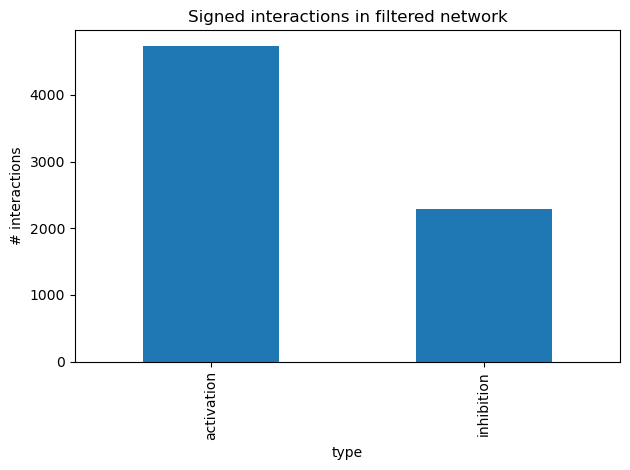

In [27]:
type_counts = df["type"].value_counts()
ax = type_counts.plot(kind="bar")
ax.set_ylabel("# interactions")
ax.set_title("Signed interactions in filtered network")
plt.tight_layout()
plt.show()

## 2.4.  Load expression table

In [29]:
from pathlib import Path
import pandas as pd

BASE = Path("/storage/users/job37yv/Projects/Franziska_faber")
EXPR_MEAN_PKL = BASE / "analysis" / "expr_mean" / "expr_mean.pkl"
EXPR_MEAN_CSV = BASE / "analysis" / "expr_mean" / "expr_mean.csv"

# pick one:
expr_mean = pd.read_pickle(EXPR_MEAN_PKL)
# expr_mean = pd.read_csv(EXPR_MEAN_CSV, index_col=0)

print(expr_mean.shape)
expr_mean.head()


(21806, 6)


condition,Bt,Cd,Co,Mock,UniProtID,gene_symbol
ENSG00000186092.6,0.314213,1.077243,0.321928,0.597730,Q8NH21,OR4F5
ENSG00000284733.1,0.000000,0.000000,0.000000,0.000000,Q6IEY1,OR4F29
ENSG00000284662.1,0.000000,0.000000,0.000000,0.000000,Q6IEY1,OR4F16
ENSG00000187634.12,5.802107,5.925841,6.027611,6.210103,Q96NU1,SAMD11
ENSG00000188976.11,9.808610,9.614422,9.558625,9.686687,Q9Y3T9,NOC2L


In [30]:
print(expr_mean.columns.tolist())

['Bt', 'Cd', 'Co', 'Mock', 'UniProtID', 'gene_symbol']


# 3. Build the network (nodes: expression; edges: omnipath) and get the biggest fuly connected componente (GCC)

## 3.1 Build network

In [32]:
# ─── Build the set of UniProt IDs actually in your filtered expr_mean ─────────
gene_set = set(expr_mean["UniProtID"].dropna().unique())
print(f"{len(gene_set):,} UniProt IDs in the expression matrix")

# ─── Now filter your OmniPath interactions df by that set ────────────────────
df_expr = df[
    df["source"].isin(gene_set) &
    df["target"].isin(gene_set)
].copy()
print(f"Edges after expression filter: {df_expr.shape[0]:,}")

# ─── And continue annotating symbols and building the igraph ─────────────────
symbol_map = dict(zip(
    expr_mean["UniProtID"],
    expr_mean["gene_symbol"]
))

df_expr["source_symbol"] = df_expr["source"].map(symbol_map)
df_expr["target_symbol"] = df_expr["target"].map(symbol_map)

import igraph as ig
edge_tuples = df_expr[["source","target","type"]].itertuples(index=False, name=None)
g_full = ig.Graph.TupleList(edge_tuples, directed=True, edge_attrs=["type"])
g_full.vs["gene_symbol"] = [symbol_map.get(name, "") for name in g_full.vs["name"]]

print(f"Global graph – nodes: {g_full.vcount()}, edges: {g_full.ecount()}")


19,070 UniProt IDs in the expression matrix
Edges after expression filter: 6,766
Global graph – nodes: 2966, edges: 6766


In [33]:
# 1. Filter to edges where both source & target were measured
df_expr = df[
    df["source"].isin(gene_set) &
    df["target"].isin(gene_set)
].copy()
print(f"Edges after expression filter: {df_expr.shape[0]:,}")

# 2. Build a mapping from UniProt ID → gene_symbol
#    (expr_mean has columns “UniProtID” and “gene_symbol”)
symbol_map = dict(zip(
    expr_mean["UniProtID"],
    expr_mean["gene_symbol"]
))

# 3. Annotate edges with source/target symbols
df_expr["source_symbol"] = df_expr["source"].map(symbol_map)
df_expr["target_symbol"] = df_expr["target"].map(symbol_map)

# 4. Build directed igraph using TupleList (type as edge attribute)

edge_tuples = df_expr[["source","target","type"]].itertuples(index=False, name=None)
g_full = ig.Graph.TupleList(
    edge_tuples,
    directed=True,
    edge_attrs=["type"]
)
print(f"Global graph – nodes: {g_full.vcount()}, edges: {g_full.ecount()}")

# 5. Annotate each vertex with its gene symbol
g_full.vs["gene_symbol"] = [ symbol_map.get(v["name"], "") for v in g_full.vs ]

# 6. (Optional) Verify a few nodes
for v in g_full.vs[:15]:
    print(f"{v['name']} → {v['gene_symbol']}")

Edges after expression filter: 6,766
Global graph – nodes: 2966, edges: 6766
P0DP24 → CALM3
P48995 → TRPC1
Q03135 → CAV1
Q14571 → ITPR2
Q13586 → STIM1
Q13507 → TRPC3
Q9UBN4 → TRPC4
Q9UL62 → TRPC5
Q9Y210 → TRPC6
Q13563 → PKD2
Q9HBA0 → TRPV4
P19235 → EPOR
Q14643 → ITPR1
Q14573 → ITPR3
O14745 → NHERF1


## 3.2 Get the vertex attributes

In [35]:
import pandas as pd

# --- 1. List available attributes -----------------------
print("Vertex attributes:", g_full.vs.attribute_names())
print("Edge attributes:  ", g_full.es.attribute_names())

# --- 2. Pull out a DataFrame of vertices ---------------
vertices = pd.DataFrame({
    "UniProtID":    g_full.vs["name"],
    "gene_symbol":  g_full.vs["gene_symbol"],
})
print(vertices.head())

# --- 3. Pull out a DataFrame of edges ------------------
# Note: igraph edges don’t automatically carry source/target names in a column,
#       so we reconstruct them via the endpoints of each edge.
edge_list = []
for e in g_full.es:
    src, tgt = g_full.vs[e.tuple[0]]["name"], g_full.vs[e.tuple[1]]["name"]
    edge_list.append({
        "source": src,
        "target": tgt,
        "type":   e["type"]
    })
edges = pd.DataFrame(edge_list)
print(edges.head())

Vertex attributes: ['name', 'gene_symbol']
Edge attributes:   ['type']
  UniProtID gene_symbol
0    P0DP24       CALM3
1    P48995       TRPC1
2    Q03135        CAV1
3    Q14571       ITPR2
4    Q13586       STIM1
   source  target        type
0  P0DP24  P48995  inhibition
1  Q03135  P48995  activation
2  Q14571  P48995  activation
3  Q13586  P48995  activation
4  P48995  Q13507  activation


## 3.3 Build a new gcc from g_full

In [37]:
import igraph as ig

# 2) Inspect available attributes (optional)
print("Vertex (node) attributes:", g_full.vs.attributes())
print("Edge attributes:", g_full.es.attributes())

# 3) Compute components (weakly for directed graphs; same for undirected)
mode = "weak"  # use "strong" if you specifically want strongly connected components
components = g_full.components(mode=mode)

# 4) Extract the largest component
largest_component = components.giant()
print(f"Full graph: {g_full.vcount()} nodes, {g_full.ecount()} edges")
print(f"Largest component: {largest_component.vcount()} nodes, {largest_component.ecount()} edges")

# 5) Use largest component for further calculations
g = largest_component

Vertex (node) attributes: ['name', 'gene_symbol']
Edge attributes: ['type']
Full graph: 2966 nodes, 6766 edges
Largest component: 2524 nodes, 6452 edges


## 3.4 Run betweenness centrality only on the GCC

In [38]:
# Compute betweenness centrality on the largest component
btwn = largest_component.betweenness(directed=True)

# Collect centrality and degree stats
central_nodes = [
    {
        "gene_symbol": v["gene_symbol"],
        "uniprot_id": v["name"],
        "betweenness": btwn[v.index],
        "in_degree": largest_component.degree(v, mode="in"),
        "out_degree": largest_component.degree(v, mode="out")
    }
    for v in largest_component.vs
]

# Make into a DataFrame
df_gcc_stats = pd.DataFrame(central_nodes)

# Sort by betweenness
df_gcc_stats.sort_values("betweenness", ascending=False, inplace=True)

# Show top 10
top_central = df_gcc_stats.head(40)
print(top_central)


    gene_symbol uniprot_id    betweenness  in_degree  out_degree
17          SRC     P12931  337784.276966         41         127
39         AKT1     P31749  335820.549973         36          82
46         TP53     P04637  212320.126420         86          39
43         CDK1     P06493  174874.071209         15         105
607      PRKACA     P17612  161828.867047         12         109
56         ABL1     P00519  150370.062440         27          75
408        EGFR     P00533  131874.254810         43          40
214       MAPK1     P28482  125274.536680         28         106
524       PRKCA     P17252  116950.614756         14          96
45       CDKN1A     P38936  109846.038641         22           8
95        CASP3     P42574  107869.867786         10          24
26       MAPK14     Q16539  107123.025996         27          60
48          ATM     Q13315  106653.515131         12          64
312       GSK3B     P49841  103789.336988         20          62
104       MAPK8     P4598

# 4. Subset networks state wise: Build per-group/state subnetworks from GCC (expression-filtered)

In [39]:
expr_mean

condition,Bt,Cd,Co,Mock,UniProtID,gene_symbol
ENSG00000186092.6,0.314213,1.077243,0.321928,0.597730,Q8NH21,OR4F5
ENSG00000284733.1,0.000000,0.000000,0.000000,0.000000,Q6IEY1,OR4F29
ENSG00000284662.1,0.000000,0.000000,0.000000,0.000000,Q6IEY1,OR4F16
ENSG00000187634.12,5.802107,5.925841,6.027611,6.210103,Q96NU1,SAMD11
ENSG00000188976.11,9.808610,9.614422,9.558625,9.686687,Q9Y3T9,NOC2L
...,...,...,...,...,...,...
ENSG00000276438.3,8.103882,7.881767,8.142209,8.136444,Q9Y5P8,PPP2R3B
ENSG00000277800.3,1.700440,2.328645,0.948601,1.690045,Q9Y458,TBX22
ENSG00000273850.3,9.089583,8.878061,9.296633,9.101678,Q9Y5P8,PPP2R3B
ENSG00000274175.1,0.033276,0.000000,0.009586,0.415037,Q9ULZ0,LOC102723655


## 4.1 Generate Group/State‐Specific (e.g. time-bin) Subnetworks Based on Expression

In [60]:
import igraph as ig

# Prepare a mapping UniProtID → gene_symbol
symbol_map = dict(zip(expr_mean["UniProtID"], expr_mean["gene_symbol"]))

# Parameters
expression_threshold = 1   # adjust as needed

# Containers for per‐group graphs
group_graphs = {}

# Iterate over each leiden_t_bin_merged_nicer group column
for group in expr_mean.columns[:-2]:   # skip the last two columns (UniProtID, gene_symbol)
    # 1) Determine which proteins are “expressed” in this group
    expressed = set(
        expr_mean.loc[expr_mean[group] > expression_threshold, "UniProtID"]
    )
    print(f"{group}: {len(expressed)} proteins above threshold {expression_threshold}")
    
    # 2) Filter interactions to those among expressed proteins
    df_sub = df[
        df["source"].isin(expressed) &
        df["target"].isin(expressed)
    ].copy()
    print(f"  → {df_sub.shape[0]} edges remain in subnetwork")
    
    # 3) Build the directed subgraph
    edge_tuples = df_sub[["source","target","type"]].itertuples(index=False, name=None)
    g_sub = ig.Graph.TupleList(
        edge_tuples,
        directed=True,
        edge_attrs=["type"]
    )
    
    # 4) Annotate nodes with gene symbols
    g_sub.vs["gene_symbol"] = [symbol_map.get(v["name"], "") for v in g_sub.vs]
    
    # 5) Store in dict
    group_graphs[group] = g_sub

# Example: inspect one group's graph
grp = list(group_graphs)[0]
print(f"\nSubnetwork for {grp}: nodes={group_graphs[grp].vcount()}, edges={group_graphs[grp].ecount()}")
for v in group_graphs[grp].vs[:5]:
    print(f"  {v['name']} ({v['gene_symbol']})")


Bt: 15836 proteins above threshold 1
  → 5893 edges remain in subnetwork
Cd: 15865 proteins above threshold 1
  → 5921 edges remain in subnetwork
Co: 15840 proteins above threshold 1
  → 5911 edges remain in subnetwork
Mock: 15984 proteins above threshold 1
  → 5932 edges remain in subnetwork

Subnetwork for Bt: nodes=2517, edges=5893
  P0DP24 (CALM3)
  P48995 (TRPC1)
  Q03135 (CAV1)
  Q14571 (ITPR2)
  Q13586 (STIM1)


## 4.2 Topological metrices (node and edge counts, centrlity) per state specific network

### Node and Edges Count

  group  nodes  edges   density   avg_deg
0    Bt   2517   5893  0.000931  4.682559
1    Cd   2522   5921  0.000931  4.695480
2    Co   2523   5911  0.000929  4.685692
3  Mock   2548   5932  0.000914  4.656201


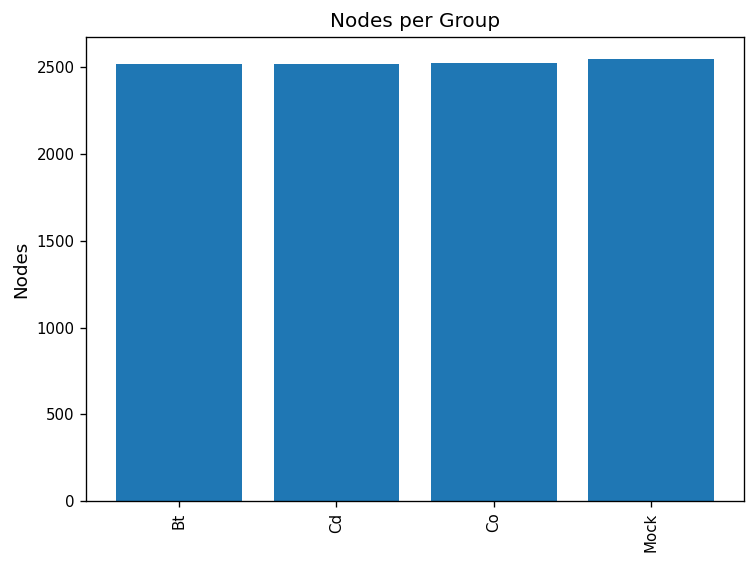

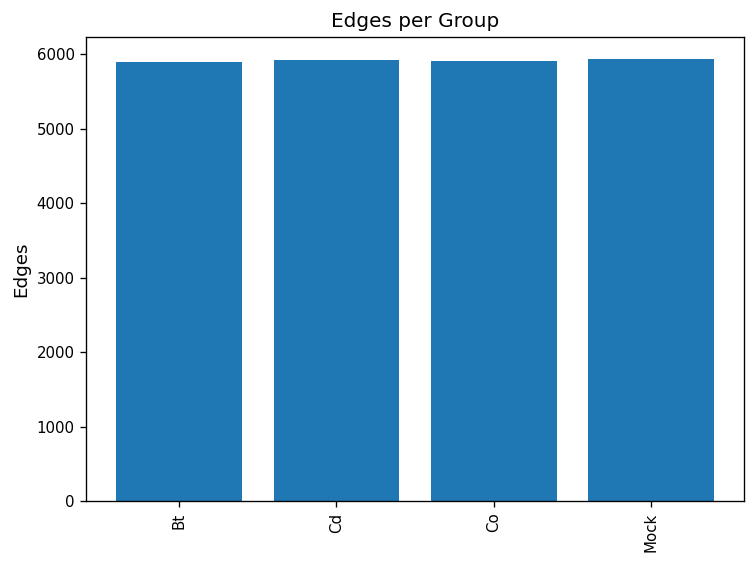

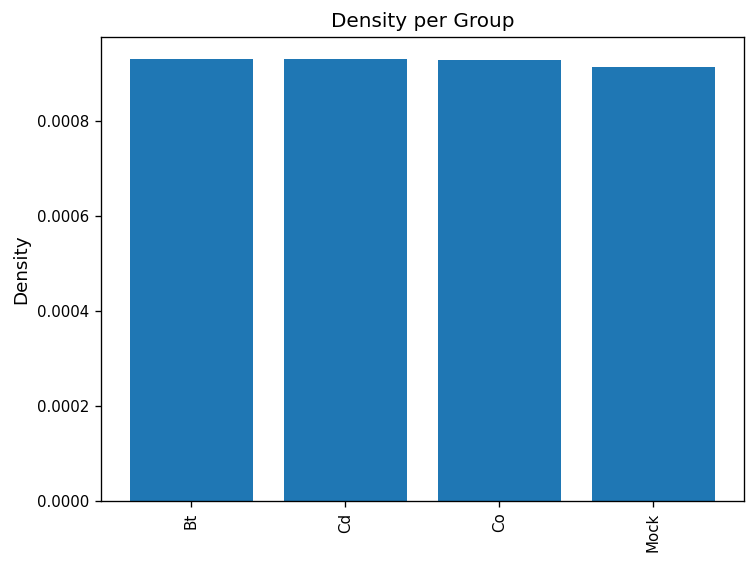

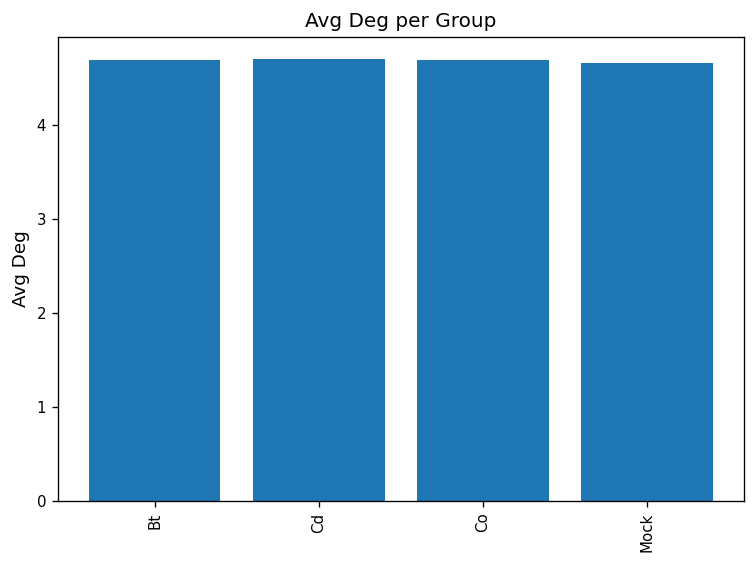

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Compute metrics per group subgraph ------------------
metrics = []
for grp, sub in group_graphs.items():
    n     = sub.vcount()
    m     = sub.ecount()
    dens  = sub.density()
    avgd  = np.mean(sub.degree()) if n>0 else 0
    metrics.append((grp, n, m, dens, avgd))

metrics = pd.DataFrame(metrics, columns=["group","nodes","edges","density","avg_deg"])
metrics = metrics.sort_values("group")

# Show the table
print(metrics)

# --- 2. Plot each metric in its own figure ---------------
for metric in ["nodes","edges","density","avg_deg"]:
    plt.figure()
    plt.bar(metrics["group"], metrics[metric])
    plt.xticks(rotation=90)
    plt.ylabel(metric.replace("_"," ").title())
    plt.title(f"{metric.replace('_',' ').title()} per Group")
    plt.tight_layout()
    plt.show()



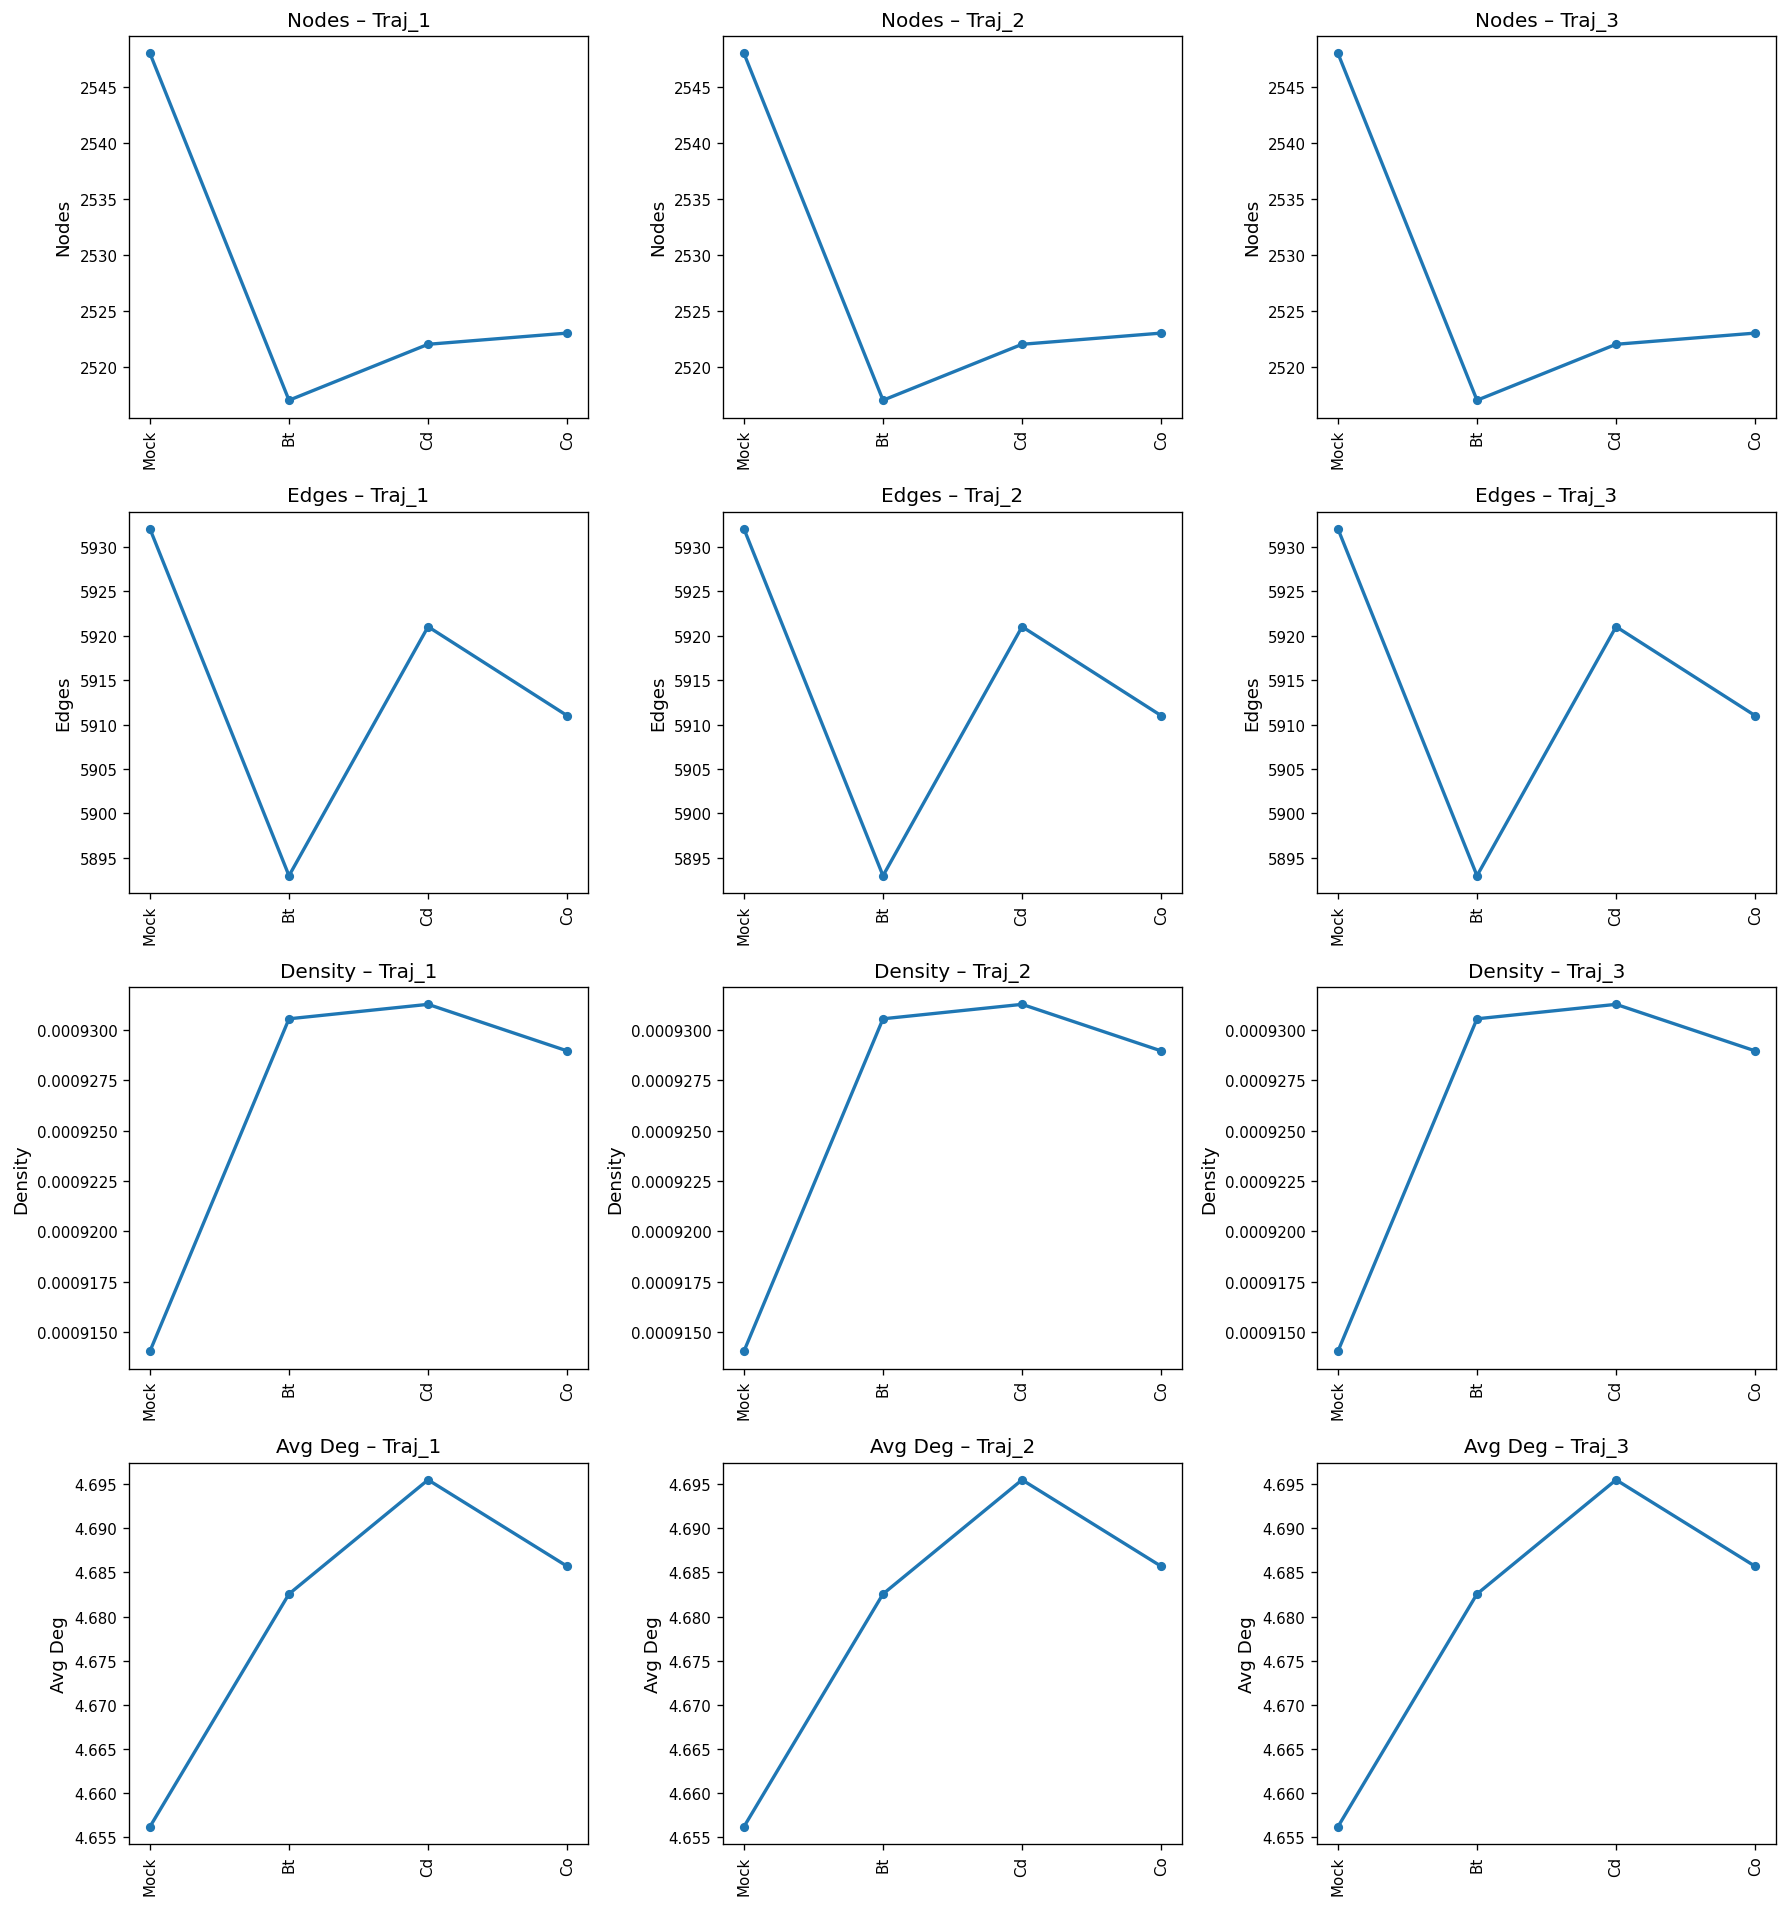

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- 1. Compute metrics per group subgraph ------------------
metrics = []
for grp, sub in group_graphs.items():
    n     = sub.vcount()
    m     = sub.ecount()
    dens  = sub.density()
    avgd  = np.mean(sub.degree()) if n > 0 else 0
    metrics.append((grp, n, m, dens, avgd))

metrics = pd.DataFrame(metrics, columns=["group", "nodes", "edges", "density", "avg_deg"])
metrics = metrics.sort_values("group")

# --- 2. Define trajectories ------------------
trajectories = {
    "Traj_1": ["Mock", "Bt", "Cd", "Co"],
    "Traj_2": ["Mock", "Bt", "Cd", "Co"],
    "Traj_3": ["Mock", "Bt", "Cd", "Co"]
}

# --- 3. Create subpanels: one row per metric, one column per trajectory ---
metrics_to_plot = ["nodes", "edges", "density", "avg_deg"]
n_metrics = len(metrics_to_plot)
n_trajectories = len(trajectories)

fig, axes = plt.subplots(nrows=n_metrics, ncols=n_trajectories, figsize=(5 * n_trajectories, 4 * n_metrics), sharex=False)

for row_idx, metric in enumerate(metrics_to_plot):
    for col_idx, (traj_name, traj_groups) in enumerate(trajectories.items()):
        ax = axes[row_idx, col_idx]

        traj_df = metrics[metrics["group"].isin(traj_groups)].copy()
        traj_df["group"] = pd.Categorical(traj_df["group"], categories=traj_groups, ordered=True)
        traj_df = traj_df.sort_values("group")

        ax.plot(traj_df["group"], traj_df[metric], marker='o', linewidth=2)
        ax.set_title(f"{metric.replace('_', ' ').title()} – {traj_name}")
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


### Degree distribution

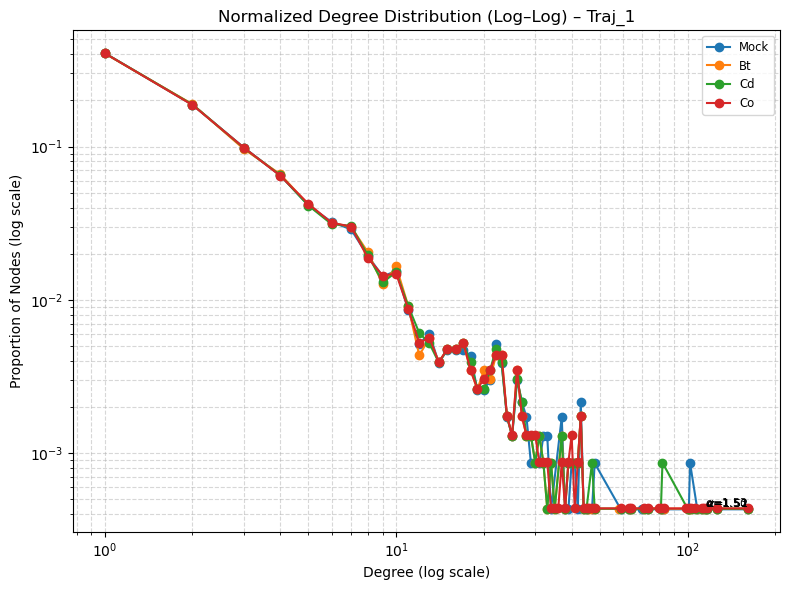

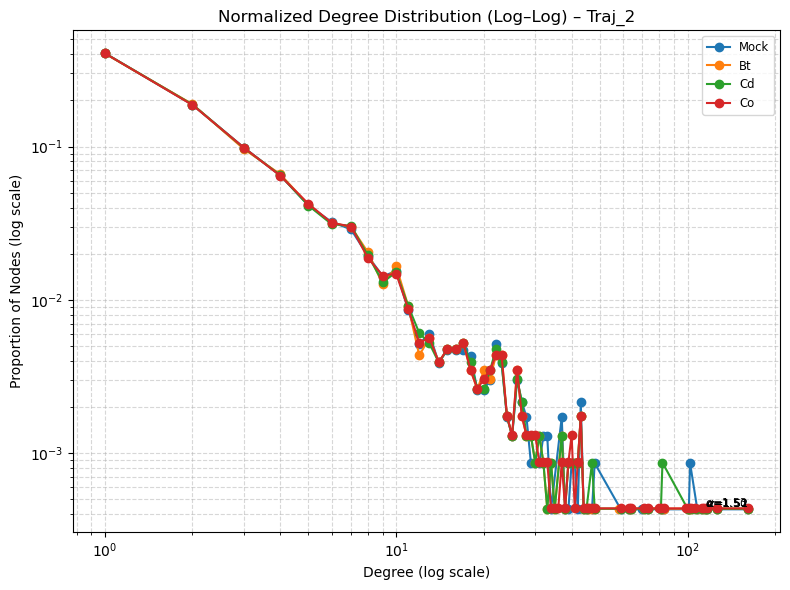

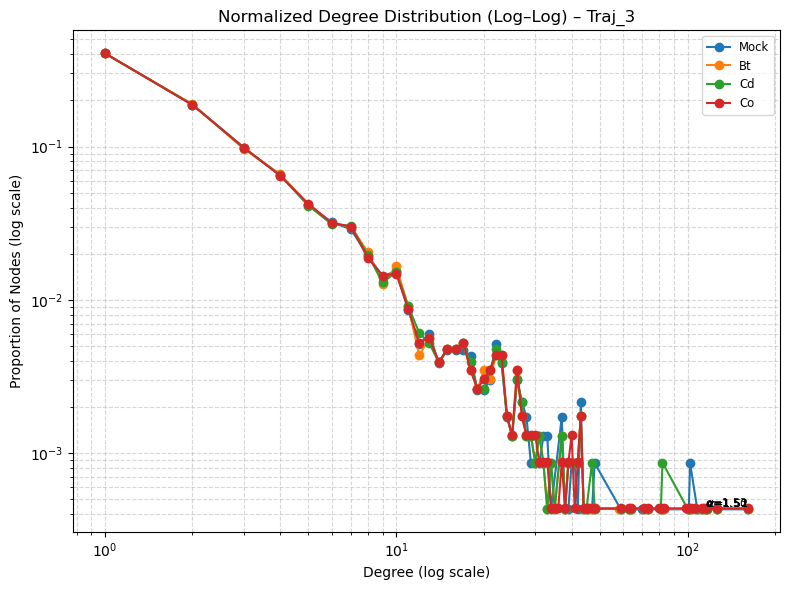

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# --- Define trajectories ---
trajectories = {
    "Traj_1": ["Mock", "Bt", "Cd", "Co"],
    "Traj_2": ["Mock", "Bt", "Cd", "Co"],
    "Traj_3": ["Mock", "Bt", "Cd", "Co"]
}


# --- Plot normalized degree distributions in log-log scale ---
for traj_name, traj_groups in trajectories.items():
    plt.figure(figsize=(8, 6))

    for group in traj_groups:
        if group not in group_graphs:
            continue

        g_sub = group_graphs[group]
        degrees = g_sub.degree()

        # Bin counts and normalize
        counts = np.bincount(degrees)
        if counts.sum() == 0:
            continue
        probs = counts / counts.sum()
        x = np.arange(len(probs))

        # Filter out zero values to avoid log(0)
        nonzero = probs > 0
        x_log = x[nonzero]
        probs_log = probs[nonzero]

        plt.plot(x_log, probs_log, marker='o', linestyle='-', label=group)

        # Fit tail to power law: P(k) ~ k^-alpha (e.g., for k >= 3)
        tail_mask = (x_log >= 3)
        if np.sum(tail_mask) > 2:
            slope, intercept, _, _, _ = linregress(np.log10(x_log[tail_mask]), np.log10(probs_log[tail_mask]))
            alpha = -slope
            plt.text(
                x_log[-1], probs_log[-1], f"$\\alpha$={alpha:.2f}", fontsize=8,
                ha="right", va="bottom"
            )

    plt.title(f"Normalized Degree Distribution (Log–Log) – {traj_name}")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Proportion of Nodes (log scale)")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(fontsize="small", loc="upper right")
    plt.tight_layout()
    plt.show()


### Betweeness centrality

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from collections import defaultdict

/tmp/ipykernel_1855692/148228363.py:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = betw_df.pivot_table(index="gene_symbol", columns="group", values="betweenness", fill_value=0.0)


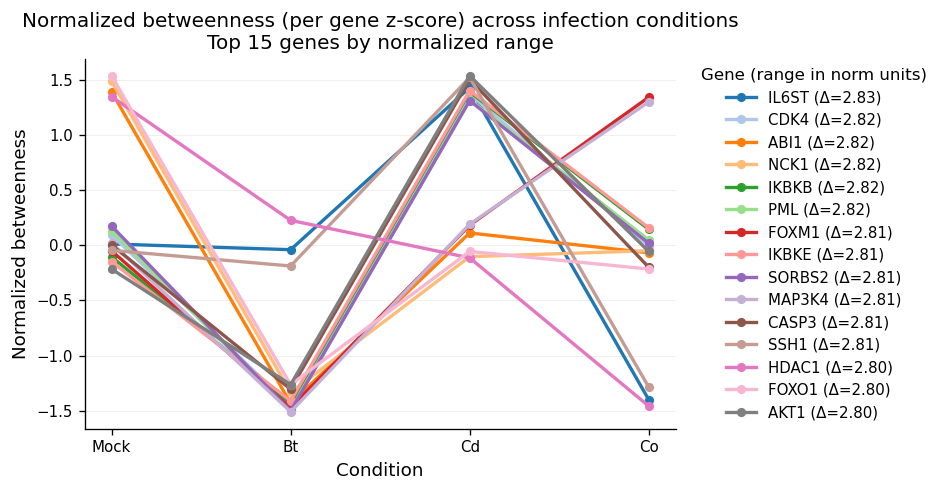

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_norm_Traj1_top15_zscore.png
[SAVED] raw, normalized, and range rank tables


In [63]:
# --- CONFIG ---
import os, numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import linregress

OUTDIR = "/bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network"
os.makedirs(OUTDIR, exist_ok=True)

COND_ORDER   = ["Mock", "Bt", "Cd", "Co"]        # Traj_1
N_SHOW       = 15                                # how many genes to plot
DPI          = 600
SHOW         = True
N_COLOR      = 20                                # fixed palette for most changing genes
NORM_METHOD  = "zscore"                          # "zscore" or "minmax"

mpl.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": DPI,
    "font.size": 10, "axes.labelsize": 11, "axes.titlesize": 12,
    "legend.fontsize": 9, "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.linewidth": 0.8, "lines.linewidth": 2.0, "lines.markersize": 4.5,
})

# -------------------------------------------------------------------
# 1) Collect betweenness per group (expects: group_graphs: dict[str -> igraph.Graph])
#     Each vertex must have attribute "gene_symbol" (like in your working code)
# -------------------------------------------------------------------
betw_rows = []
for grp, ig in group_graphs.items():
    if grp not in COND_ORDER:
        continue
    bt = ig.betweenness(directed=True)  # weights=None by default
    for v, score in zip(ig.vs, bt):
        betw_rows.append({"group": grp, "gene_symbol": v["gene_symbol"], "betweenness": float(score)})

betw_df = pd.DataFrame(betw_rows)
# keep only the trajectory groups, in the right order
betw_df = betw_df[betw_df["group"].isin(COND_ORDER)].copy()
betw_df["group"] = pd.Categorical(betw_df["group"], categories=COND_ORDER, ordered=True)

# pivot → rows=genes, cols=conditions, values=betweenness (fill missing with 0)
pivot = betw_df.pivot_table(index="gene_symbol", columns="group", values="betweenness", fill_value=0.0)
pivot = pivot.reindex(columns=COND_ORDER)  # ensure order

# -------------------------------------------------------------------
# 2) Normalize across conditions per gene (row-wise)
#    z-score (recommended): (x - mean)/std  ; constant rows -> 0
#    min-max (optional): (x - min)/(max-min) ; constant rows -> 0
# -------------------------------------------------------------------
def normalize_rows(df, method="zscore"):
    A = df.values.astype(float)
    if method == "zscore":
        mu = A.mean(axis=1, keepdims=True)
        sd = A.std(axis=1, ddof=0, keepdims=True)
        sd[sd == 0] = 1.0
        Z = (A - mu) / sd
        return pd.DataFrame(Z, index=df.index, columns=df.columns)
    elif method == "minmax":
        mn = A.min(axis=1, keepdims=True)
        mx = A.max(axis=1, keepdims=True)
        rng = mx - mn
        rng[rng == 0] = 1.0
        MM = (A - mn) / rng
        return pd.DataFrame(MM, index=df.index, columns=df.columns)
    else:
        raise ValueError("method must be 'zscore' or 'minmax'.")

pivot_norm = normalize_rows(pivot, method=NORM_METHOD)

# -------------------------------------------------------------------
# 3) Rank genes by magnitude of change across conditions (range of normalized values)
# -------------------------------------------------------------------
change = (pivot_norm.max(axis=1) - pivot_norm.min(axis=1)).rename("range_norm")
top_genes = change.sort_values(ascending=False).head(max(N_SHOW, N_COLOR)).index.tolist()

# color map for the overall top N_COLOR changing genes (fixed across plot)
cmap = plt.get_cmap("tab20")
gene_colors = {g: cmap(i % 20) for i, g in enumerate(top_genes[:N_COLOR])}
FALLBACK = (0.6, 0.6, 0.6)

# -------------------------------------------------------------------
# 4) Plot the top N_SHOW genes (normalized betweenness), all in one panel
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.2))
genes_to_plot = top_genes[:N_SHOW]

for gene in genes_to_plot:
    y = pivot_norm.loc[gene, COND_ORDER].values.astype(float)
    ax.plot(COND_ORDER, y, marker="o", linewidth=2.0, markersize=4.5,
            label=f"{gene} (Δ={change.loc[gene]:.2f})",
            color=gene_colors.get(gene, FALLBACK))

ax.set_title(f"Normalized betweenness (per gene z-score) across infection conditions\nTop {N_SHOW} genes by normalized range")
ax.set_xlabel("Condition")
ax.set_ylabel("Normalized betweenness")
ax.grid(True, which="major", axis="y", linewidth=0.4, alpha=0.3)
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.legend(title="Gene (range in norm units)", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
fig.tight_layout()

out_png = os.path.join(OUTDIR, f"betweenness_norm_Traj1_top{N_SHOW}_{NORM_METHOD}.png")
fig.savefig(out_png, bbox_inches="tight", transparent=True)
if SHOW:
    plt.show()
plt.close(fig)

print("[SAVED]", out_png)

# -------------------------------------------------------------------
# 5) Also save the underlying tables for reproducibility
# -------------------------------------------------------------------
pivot.to_csv(os.path.join(OUTDIR, "betweenness_raw_Traj1.csv"))
pivot_norm.to_csv(os.path.join(OUTDIR, f"betweenness_norm_Traj1_{NORM_METHOD}.csv"))
change.sort_values(ascending=False).to_csv(os.path.join(OUTDIR, f"betweenness_norm_range_rank_Traj1_{NORM_METHOD}.csv"))
print("[SAVED] raw, normalized, and range rank tables")


/tmp/ipykernel_1855692/1829344799.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_raw = betw_df.pivot_table(index="gene_symbol", columns="condition", values="betweenness", fill_value=0.0)


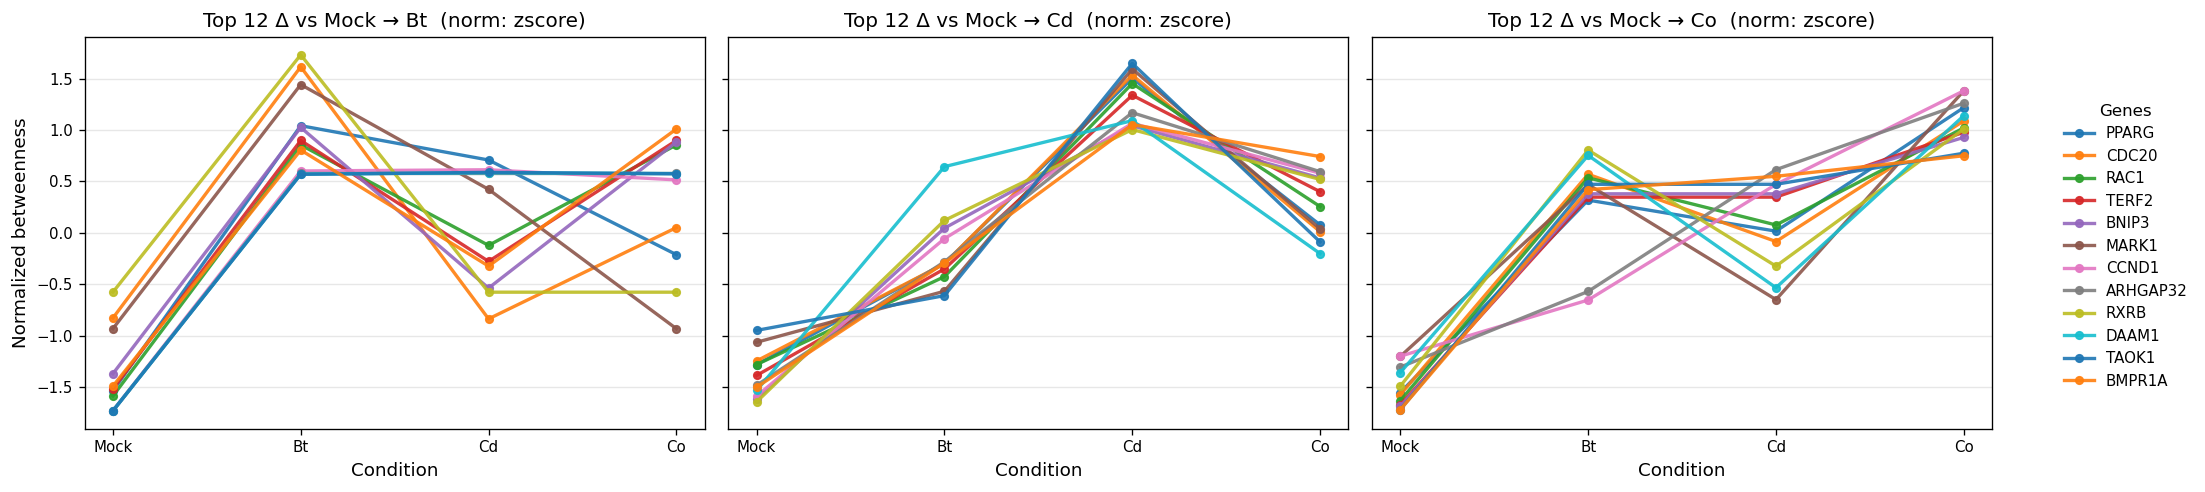

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_norm_top_vs_Mock.png

=== Top 12 increases: Bt - Mock (normalized) ===
gene_symbol    delta  mock_norm  Bt_norm    mock_raw      Bt_raw
     BAIAP2 2.580612  -1.538289 1.042323  183.226050  184.357363
    MAP3K14 2.444433  -0.829184 1.615250 2837.038613 2883.171390
      BMPR2 2.443389  -1.588203 0.855186    5.000000   10.000000
       RXRG 2.417795  -1.519286 0.898508  211.379225  212.612543
      ROCK2 2.396032  -1.370959 1.025073  559.490768  560.360768
       TANK 2.375264  -0.932807 1.442457   50.372634   52.683233
        NBN 2.332765  -1.730793 0.601972 6590.806530 6922.594904
      NUAK2 2.309401  -1.732051 0.577350   34.946057   35.312723
    MAP3K12 2.309401  -0.577350 1.732051   67.680315   67.846981
      S1PR1 2.303657  -1.732034 0.571624    0.000000 1342.190341
       EYA1 2.301184  -1.732008 0.569176    0.000000 1316.000000
       RXRB 2.297176  -1.491797 0.805379  998.216532 1004.178171


In [64]:
# === Biggest increases vs Mock: Bt, Cd, Co ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- config ---
OUTDIR = "/bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network"
os.makedirs(OUTDIR, exist_ok=True)
COND_ORDER = ["Mock","Bt","Cd","Co"]
TARGETS    = ["Bt","Cd","Co"]
N_TOP      = 12       # how many genes to plot/print per comparison
NORM       = "zscore" # "zscore" or "minmax"
DPI        = 400
plt.rcParams.update({"figure.dpi":120, "savefig.dpi":DPI})

# --- 1) Collect raw betweenness per condition from igraph graphs ---
# expects: group_graphs: dict[str -> igraph.Graph], vertex attribute "gene_symbol"
rows = []
for cond in COND_ORDER:
    if cond not in group_graphs:
        continue
    g = group_graphs[cond]
    bt = g.betweenness(directed=True)
    for v, score in zip(g.vs, bt):
        rows.append({"condition": cond, "gene_symbol": v["gene_symbol"], "betweenness": float(score)})

betw_df = pd.DataFrame(rows)
betw_df = betw_df[betw_df["condition"].isin(COND_ORDER)]
betw_df["condition"] = pd.Categorical(betw_df["condition"], categories=COND_ORDER, ordered=True)

# pivot to genes × conditions
pivot_raw = betw_df.pivot_table(index="gene_symbol", columns="condition", values="betweenness", fill_value=0.0)
pivot_raw = pivot_raw.reindex(columns=COND_ORDER)

# --- 2) Normalize per gene across conditions (z-score recommended) ---
def normalize_rows(df, method="zscore"):
    A = df.values.astype(float)
    if method == "zscore":
        mu = A.mean(axis=1, keepdims=True)
        sd = A.std(axis=1, ddof=0, keepdims=True); sd[sd==0] = 1.0
        Z = (A - mu)/sd
        return pd.DataFrame(Z, index=df.index, columns=df.columns)
    elif method == "minmax":
        mn = A.min(axis=1, keepdims=True)
        mx = A.max(axis=1, keepdims=True)
        rg = mx - mn; rg[rg==0] = 1.0
        MM = (A - mn)/rg
        return pd.DataFrame(MM, index=df.index, columns=df.columns)
    else:
        raise ValueError("NORM must be 'zscore' or 'minmax'.")

pivot_norm = normalize_rows(pivot_raw, method=NORM)

# --- 3) Compute deltas vs Mock and pick top genes per target ---
results = {}  # target -> DataFrame with columns: gene_symbol, delta, mock, target
for tgt in TARGETS:
    if "Mock" not in pivot_norm.columns or tgt not in pivot_norm.columns:
        continue
    delta = (pivot_norm[tgt] - pivot_norm["Mock"]).rename("delta")
    mock_vals   = pivot_norm["Mock"].rename("mock_norm")
    target_vals = pivot_norm[tgt].rename(f"{tgt}_norm")

    top = (pd.concat([delta, mock_vals, target_vals], axis=1)
             .sort_values("delta", ascending=False)
             .head(N_TOP))
    top = top.reset_index().rename(columns={"index":"gene_symbol"})
    results[tgt] = top

# --- 4) Plot three panels (Bt, Cd, Co) showing full normalized trajectories for top genes by delta ---
fig, axes = plt.subplots(1, len(TARGETS), figsize=(5.6*len(TARGETS), 4.2), sharey=True)
if len(TARGETS) == 1:
    axes = [axes]

for ax, tgt in zip(axes, TARGETS):
    if tgt not in results or results[tgt].empty:
        ax.set_title(f"{tgt} (no data)")
        ax.axis("off")
        continue
    genes = results[tgt]["gene_symbol"].tolist()
    # plot each gene's normalized trajectory across all conditions
    for gene in genes:
        y = pivot_norm.loc[gene, COND_ORDER].values.astype(float)
        ax.plot(COND_ORDER, y, marker="o", linewidth=2, alpha=0.9, label=f"{gene}")
    ax.set_title(f"Top {N_TOP} Δ vs Mock → {tgt}  (norm: {NORM})")
    ax.set_xlabel("Condition")
    ax.grid(True, axis="y", alpha=0.3)
axes[0].set_ylabel("Normalized betweenness")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, title="Genes")
fig.tight_layout()
out_png = os.path.join(OUTDIR, f"betweenness_norm_top_vs_Mock.png")
fig.savefig(out_png, bbox_inches="tight", transparent=True)
plt.show()
print("[SAVED]", out_png)

# --- 5) Print short ranked summaries & save CSVs ---
for tgt in TARGETS:
    if tgt not in results: 
        continue
    print(f"\n=== Top {N_TOP} increases: {tgt} - Mock (normalized) ===")
    df = results[tgt].copy()
    # also attach raw values for context
    df["mock_raw"] = pivot_raw.loc[df["gene_symbol"], "Mock"].values
    df[f"{tgt}_raw"] = pivot_raw.loc[df["gene_symbol"], tgt].values
    print(df[["gene_symbol","delta","mock_norm",f"{tgt}_norm","mock_raw",f"{tgt}_raw"]].to_string(index=False))
    df.to_csv(os.path.join(OUTDIR, f"top_{N_TOP}_delta_{tgt}_vs_Mock.csv"), index=False)

# also keep the full matrices
pivot_raw.to_csv(os.path.join(OUTDIR, "betweenness_raw_all.csv"))
pivot_norm.to_csv(os.path.join(OUTDIR, f"betweenness_norm_all_{NORM}.csv"))
print("\n[OK] Wrote full raw & normalized betweenness matrices.")


In [65]:
# === Biggest increases/decreases vs Mock across ALL targets ===
TOP_N = 30

# compute all deltas (Bt, Cd, Co vs Mock)
all_deltas = []
for tgt in TARGETS:
    if "Mock" not in pivot_norm.columns or tgt not in pivot_norm.columns:
        continue
    delta = (pivot_norm[tgt] - pivot_norm["Mock"]).rename("delta")
    tmp = pd.DataFrame({
        "gene_symbol": pivot_norm.index,
        "target": tgt,
        "delta": delta.values,
        "mock_norm": pivot_norm["Mock"].values,
        f"{tgt}_norm": pivot_norm[tgt].values,
        "mock_raw": pivot_raw["Mock"].values,
        f"{tgt}_raw": pivot_raw[tgt].values,
    })
    all_deltas.append(tmp)

all_deltas = pd.concat(all_deltas, ignore_index=True)

# rank by biggest increase and decrease
top_up   = all_deltas.sort_values("delta", ascending=False).head(TOP_N)
top_down = all_deltas.sort_values("delta", ascending=True).head(TOP_N)

# print summaries
print(f"\n=== Global Top {TOP_N} UP (Mock → Infected, normalized) ===")
print(top_up[["gene_symbol","target","delta","mock_norm",f"{tgt}_norm","mock_raw",f"{tgt}_raw"]].to_string(index=False))

print(f"\n=== Global Top {TOP_N} DOWN (Mock → Infected, normalized) ===")
print(top_down[["gene_symbol","target","delta","mock_norm",f"{tgt}_norm","mock_raw",f"{tgt}_raw"]].to_string(index=False))

# save
top_up.to_csv(os.path.join(OUTDIR, f"top{TOP_N}_global_up.csv"), index=False)
top_down.to_csv(os.path.join(OUTDIR, f"top{TOP_N}_global_down.csv"), index=False)

print(f"\n[OK] Global Top{TOP_N} up/down saved in {OUTDIR}")



=== Global Top 30 UP (Mock → Infected, normalized) ===
gene_symbol target    delta  mock_norm  Co_norm     mock_raw       Co_raw
      TIAM1     Cd 2.785676  -1.281732      NaN  6114.238876          NaN
    GADD45A     Cd 2.781254  -1.246114      NaN 29250.490199          NaN
      PPARG     Co 2.772160  -1.553394 1.218766  4502.212705  4521.742306
      MAML1     Cd 2.734346  -1.281629      NaN   825.490604          NaN
       RNF8     Cd 2.726064  -1.387563      NaN  2693.221839          NaN
      CDC20     Co 2.664655  -1.575076 1.089579   160.489888   161.954982
        ATM     Cd 2.662785  -1.621045      NaN 86576.061592          NaN
      UBE2N     Cd 2.659080  -1.064608      NaN  3340.329075          NaN
       CHUK     Cd 2.654568  -1.588961      NaN 21831.885152          NaN
       RAC1     Co 2.653606  -1.632593 1.021013 67688.336549 68326.788523
     RICTOR     Cd 2.652353  -1.483191      NaN   329.598498          NaN
      TERF2     Co 2.652338  -1.673499 0.978839    73.77

/tmp/ipykernel_1855692/686069769.py:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_raw = betw_df.pivot_table(index="gene_symbol", columns="condition", values="betweenness", fill_value=0.0)



=== Mock → Bt : Top 12 UP (normalized delta = Bt-Mock) ===
gene_symbol    delta  Mock_norm  Bt_norm    Mock_raw      Bt_raw
     BAIAP2 2.580612  -1.538289 1.042323  183.226050  184.357363
    MAP3K14 2.444433  -0.829184 1.615250 2837.038613 2883.171390
      BMPR2 2.443389  -1.588203 0.855186    5.000000   10.000000
       RXRG 2.417795  -1.519286 0.898508  211.379225  212.612543
      ROCK2 2.396032  -1.370959 1.025073  559.490768  560.360768
       TANK 2.375264  -0.932807 1.442457   50.372634   52.683233
        NBN 2.332765  -1.730793 0.601972 6590.806530 6922.594904
      NUAK2 2.309401  -1.732051 0.577350   34.946057   35.312723
    MAP3K12 2.309401  -0.577350 1.732051   67.680315   67.846981
      S1PR1 2.303657  -1.732034 0.571624    0.000000 1342.190341
       EYA1 2.301184  -1.732008 0.569176    0.000000 1316.000000
       RXRB 2.297176  -1.491797 0.805379  998.216532 1004.178171

=== Mock → Bt : Top 12 DOWN (normalized delta = Bt-Mock) ===
gene_symbol     delta  Mock_norm 

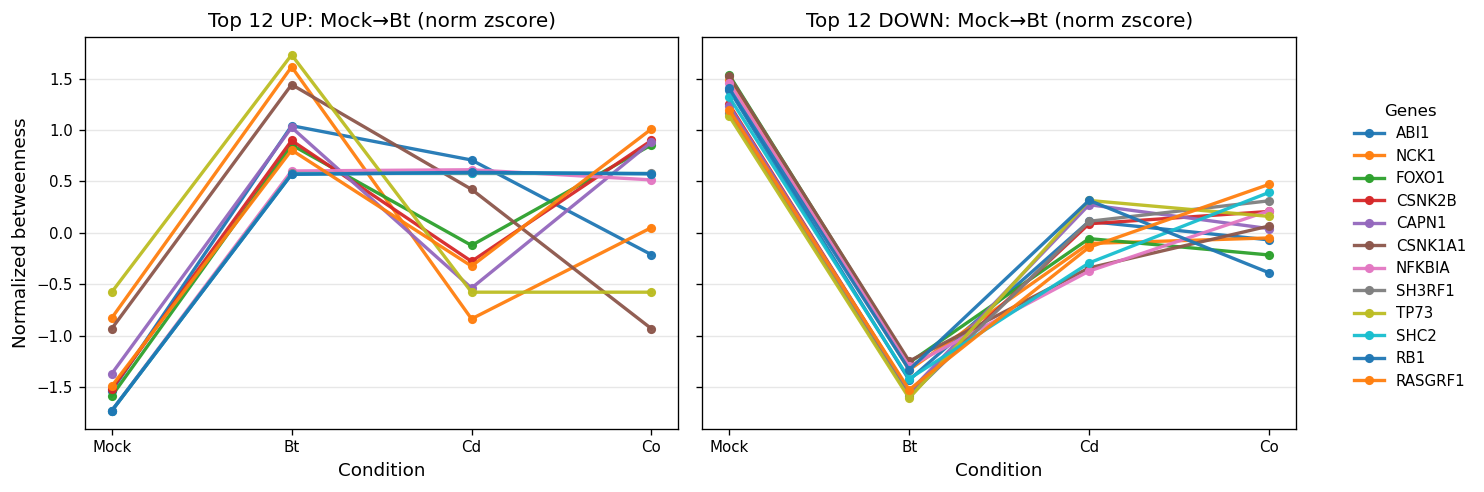

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_UP_Mock_to_Bt.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_DOWN_Mock_to_Bt.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_Mock_to_Bt_topUP_DOWN.png

=== Mock → Cd : Top 12 UP (normalized delta = Cd-Mock) ===
gene_symbol    delta  Mock_norm  Cd_norm     Mock_raw       Cd_raw
      TIAM1 2.785676  -1.281732 1.503944  6114.238876  6212.965433
    GADD45A 2.781254  -1.246114 1.535140 29250.490199 29569.272151
      MAML1 2.734346  -1.281629 1.452717   825.490604   829.018967
       RNF8 2.726064  -1.387563 1.338501  2693.221839  2722.267338
        ATM 2.662785  -1.621045 1.041740 86576.061592 87586.267050
      UBE2N 2.659080  -1.064608 1.594472  3340.329075  3379.060180
       CHUK 2.654568  -1.588961 1.065607 21831.885152 22466.457571
     RICTOR 2.652353  -1.483191 1.169163   329.598498   334.219087
        PGR 2.649699  -1.644966

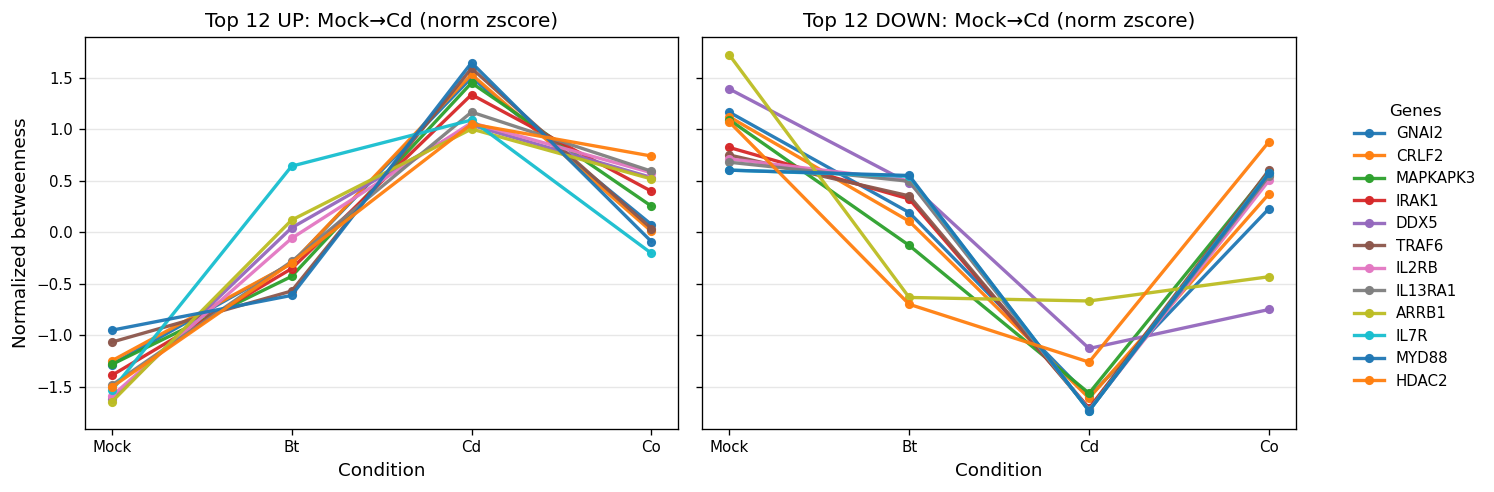

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_UP_Mock_to_Cd.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_DOWN_Mock_to_Cd.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_Mock_to_Cd_topUP_DOWN.png

=== Mock → Co : Top 12 UP (normalized delta = Co-Mock) ===
gene_symbol    delta  Mock_norm  Co_norm     Mock_raw       Co_raw
      PPARG 2.772160  -1.553394 1.218766  4502.212705  4521.742306
      CDC20 2.664655  -1.575076 1.089579   160.489888   161.954982
       RAC1 2.653606  -1.632593 1.021013 67688.336549 68326.788523
      TERF2 2.652338  -1.673499 0.978839    73.772312    74.472312
      BNIP3 2.616532  -1.688029 0.928504    81.717624    84.509291
      MARK1 2.584910  -1.202605 1.382305    56.047057    57.180391
      CCND1 2.582342  -1.199933 1.382409  5250.943296  5278.369716
   ARHGAP32 2.567519  -1.305994 1.261525  2507.840262  2515.302466
       RXRB 2.502210  -1.491797

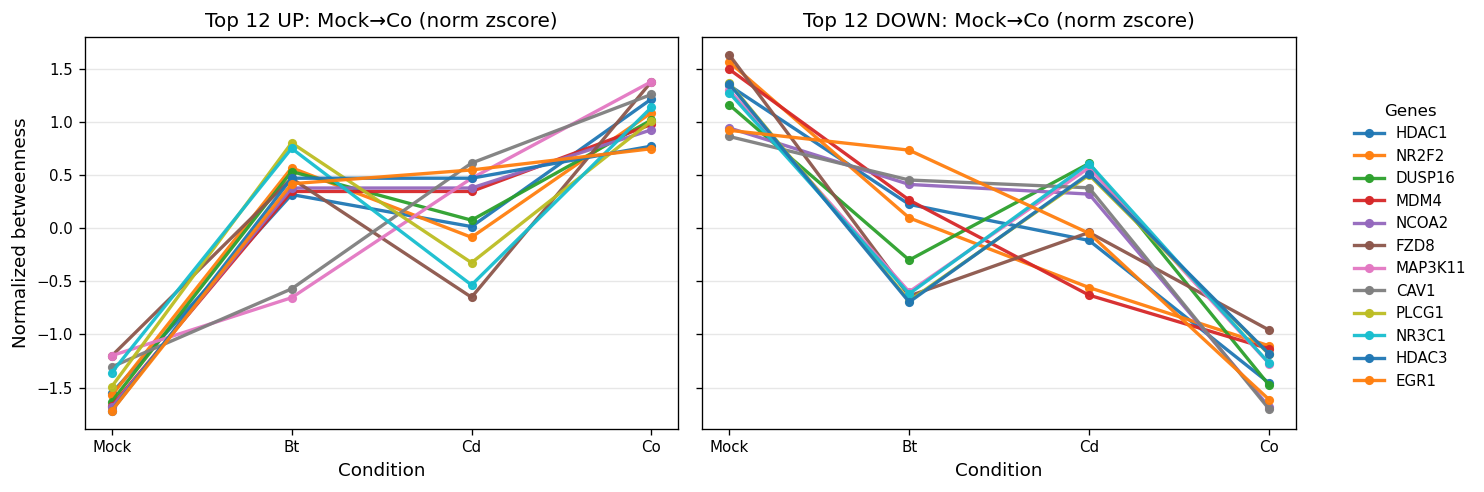

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_UP_Mock_to_Co.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_DOWN_Mock_to_Co.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_Mock_to_Co_topUP_DOWN.png

=== Bt → Cd : Top 12 UP (normalized delta = Cd-Bt) ===
gene_symbol    delta   Bt_norm  Cd_norm        Bt_raw        Cd_raw
       CDK4 2.824050 -1.455344 1.368706  21801.235852  21937.071502
      IKBKB 2.816895 -1.427965 1.388930  29936.947867  30720.566546
        PML 2.815958 -1.496862 1.319096   2751.499661   2758.673472
      IKBKE 2.811825 -1.410683 1.401141   3338.650947   3433.025753
     SORBS2 2.811142 -1.501090 1.310052    170.942215    172.227930
      CASP3 2.807200 -1.304488 1.502712  98197.801957  99987.386145
       AKT1 2.797543 -1.262618 1.534926 281879.943928 286721.622666
      CASP6 2.795713 -1.382190 1.413523   1703.088392   1724.494298
        EZR 2.795104 -1.25

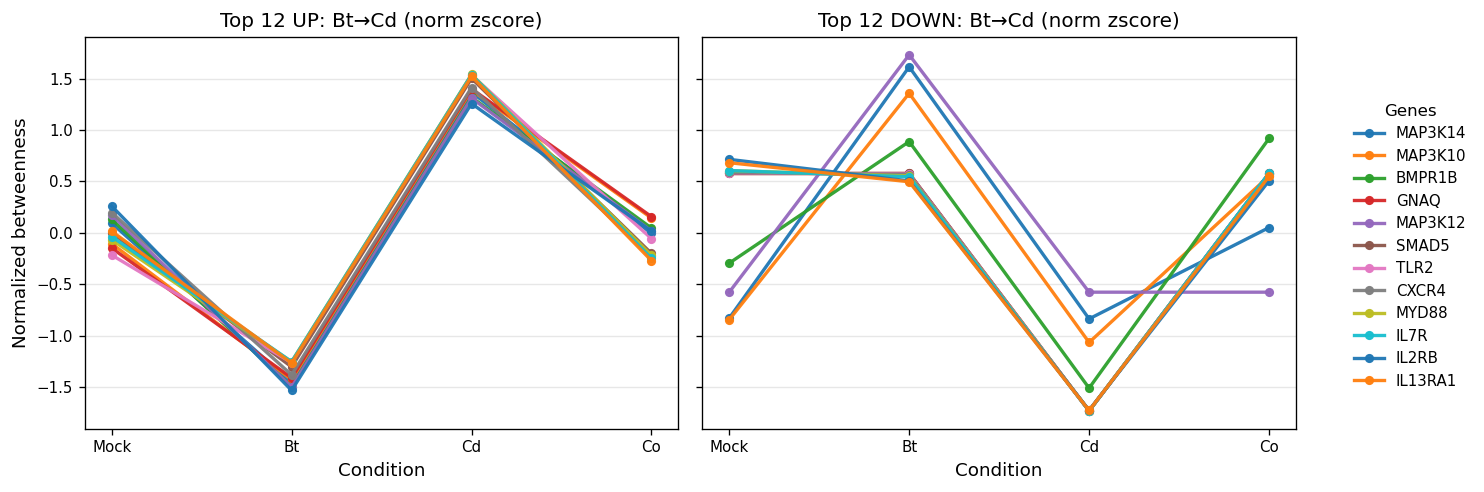

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_UP_Bt_to_Cd.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_DOWN_Bt_to_Cd.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_Bt_to_Cd_topUP_DOWN.png

=== Bt → Co : Top 12 UP (normalized delta = Co-Bt) ===
gene_symbol    delta   Bt_norm  Co_norm      Bt_raw      Co_raw
      FOXM1 2.812798 -1.471714 1.341084 7251.850839 7282.958340
     MAP3K4 2.807366 -1.509531 1.297835 2497.529758 2517.598401
     PPP3CA 2.785242 -1.566699 1.218544   79.706744   81.040077
      SH2B2 2.783279 -1.565421 1.217858  141.715931  144.924265
       WNK4 2.769728 -1.428447 1.341281  308.518289  311.624109
     PPP1R2 2.745747 -1.276023 1.469724  644.246063  651.220091
       E2F2 2.738050 -1.339651 1.398399  170.442223  172.143329
      DAPK3 2.734288 -1.191800 1.542489  587.313472  588.003032
       GRB7 2.734043 -1.110846 1.623197   35.774016   36.387148
    

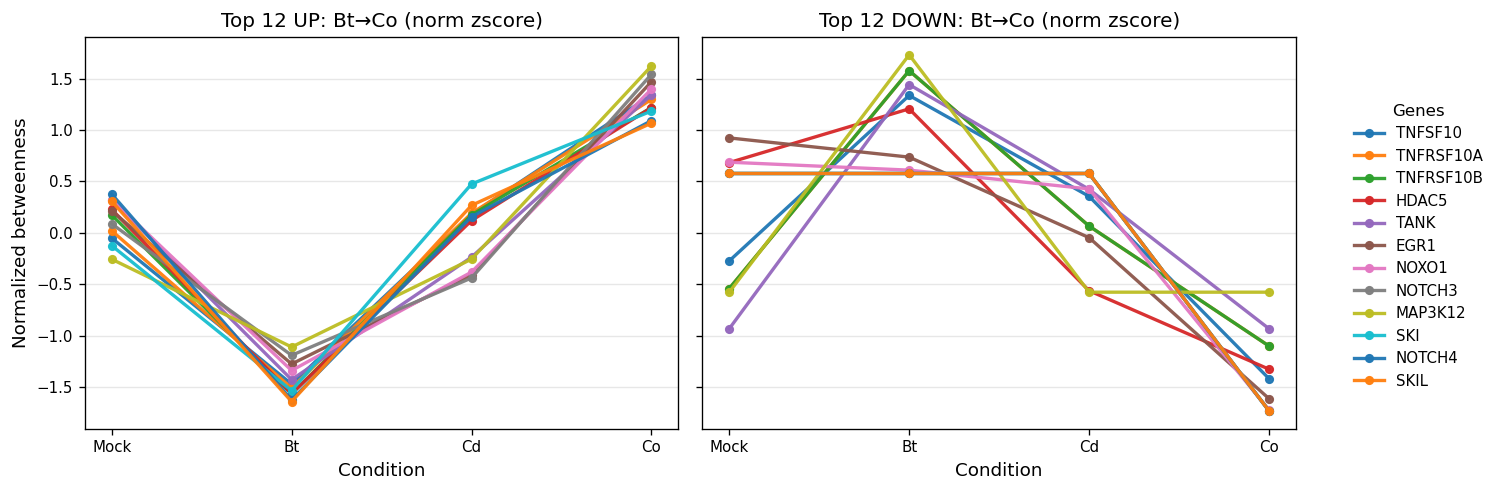

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_UP_Bt_to_Co.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_DOWN_Bt_to_Co.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_Bt_to_Co_topUP_DOWN.png

=== Cd → Co : Top 12 UP (normalized delta = Co-Cd) ===
gene_symbol    delta   Cd_norm  Co_norm      Cd_raw      Co_raw
      NOLC1 2.792605 -1.397390 1.395215 2216.106166 2258.685279
     MAP2K7 2.753829 -1.596332 1.157497 2472.814370 2483.547843
       WWOX 2.736832 -1.221557 1.515275  332.479009  342.784447
     PPP1R8 2.719546 -1.096209 1.623336  170.058587  175.236712
   CDC42BPA 2.667514 -1.111171 1.556343  103.283697  104.639747
       DAB1 2.640921 -0.987402 1.653519  918.197979  958.796243
   ARHGAP35 2.551158 -0.949378 1.601780  382.584679  397.125021
       ABL2 2.538070 -0.838354 1.699716  275.784385  282.863964
    RPS6KB2 2.523345 -0.815614 1.707731   47.443760   48.601150
    

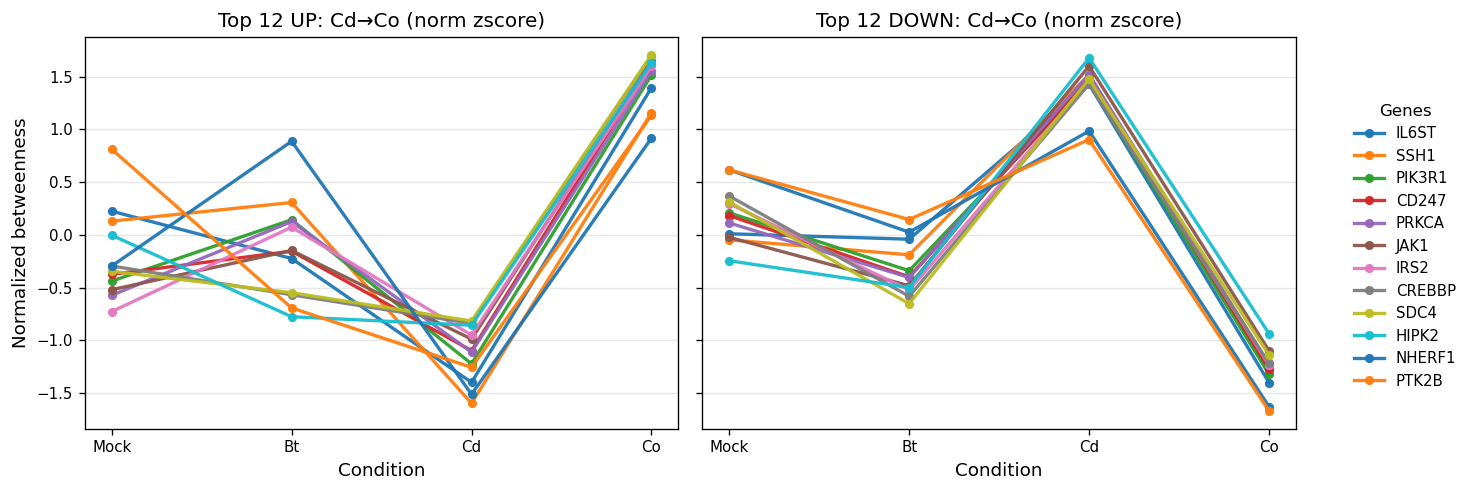

[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_UP_Cd_to_Co.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/top_12_DOWN_Cd_to_Co.csv
[SAVED] /bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network/betweenness_Cd_to_Co_topUP_DOWN.png

[OK] Wrote full raw & normalized betweenness matrices.


In [66]:
# === Pairwise biggest increases/decreases in normalized betweenness ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- config ---
OUTDIR = "/bigstorage/users/job37yv/Projects/PANC_cancer/analysis/network"
os.makedirs(OUTDIR, exist_ok=True)
COND_ORDER = ["Mock","Bt","Cd","Co"]
PAIRS     = [("Mock","Bt"), ("Mock","Cd"), ("Mock","Co"),
             ("Bt","Cd"), ("Bt","Co"), ("Cd","Co")]
N_TOP      = 12        # top up & top down per pair
NORM       = "zscore"  # "zscore" or "minmax"
DPI        = 400
plt.rcParams.update({"figure.dpi":120, "savefig.dpi":DPI})

# --- 1) Collect raw betweenness per condition from igraph graphs ---
# expects: group_graphs: dict[str -> igraph.Graph], vertex attribute "gene_symbol"
rows = []
for cond in COND_ORDER:
    if cond not in group_graphs:
        continue
    g = group_graphs[cond]
    bt = g.betweenness(directed=True)
    for v, score in zip(g.vs, bt):
        rows.append({"condition": cond, "gene_symbol": v["gene_symbol"], "betweenness": float(score)})

betw_df = pd.DataFrame(rows)
betw_df = betw_df[betw_df["condition"].isin(COND_ORDER)]
betw_df["condition"] = pd.Categorical(betw_df["condition"], categories=COND_ORDER, ordered=True)

# genes × conditions matrix
pivot_raw = betw_df.pivot_table(index="gene_symbol", columns="condition", values="betweenness", fill_value=0.0)
pivot_raw = pivot_raw.reindex(columns=COND_ORDER)

# --- 2) Normalize per gene across conditions ---
def normalize_rows(df, method="zscore"):
    A = df.values.astype(float)
    if method == "zscore":
        mu = A.mean(axis=1, keepdims=True)
        sd = A.std(axis=1, ddof=0, keepdims=True); sd[sd==0] = 1.0
        Z = (A - mu)/sd
        return pd.DataFrame(Z, index=df.index, columns=df.columns)
    elif method == "minmax":
        mn = A.min(axis=1, keepdims=True)
        mx = A.max(axis=1, keepdims=True)
        rg = mx - mn; rg[rg==0] = 1.0
        MM = (A - mn)/rg
        return pd.DataFrame(MM, index=df.index, columns=df.columns)
    else:
        raise ValueError("NORM must be 'zscore' or 'minmax'.")

pivot_norm = normalize_rows(pivot_raw, method=NORM)

# --- 3) helper: build top up/down tables for a pair, then plot both panels ---
def pair_top_tables(a, b, n=N_TOP):
    """Return (top_up, top_down) by delta = b - a in normalized space."""
    delta = (pivot_norm[b] - pivot_norm[a]).rename("delta")
    df = pd.DataFrame({
        "gene_symbol": pivot_norm.index,
        f"{a}_norm": pivot_norm[a].values, f"{b}_norm": pivot_norm[b].values,
        f"{a}_raw":  pivot_raw[a].values,  f"{b}_raw":  pivot_raw[b].values,
        "delta": delta.values
    }).set_index("gene_symbol")
    top_up   = df.sort_values("delta", ascending=False).head(n).reset_index()
    top_down = df.sort_values("delta", ascending=True ).head(n).reset_index()
    return top_up, top_down

def plot_pair(a, b, top_up, top_down, fname):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), sharey=True)
    # left: top-up (b >> a)
    for gene in top_up["gene_symbol"]:
        y = pivot_norm.loc[gene, COND_ORDER].values.astype(float)
        axes[0].plot(COND_ORDER, y, marker="o", linewidth=2, alpha=0.95, label=gene)
    axes[0].set_title(f"Top {len(top_up)} UP: {a}→{b} (norm {NORM})")
    axes[0].set_xlabel("Condition"); axes[0].grid(True, axis="y", alpha=0.3)

    # right: top-down (b << a)
    for gene in top_down["gene_symbol"]:
        y = pivot_norm.loc[gene, COND_ORDER].values.astype(float)
        axes[1].plot(COND_ORDER, y, marker="o", linewidth=2, alpha=0.95, label=gene)
    axes[1].set_title(f"Top {len(top_down)} DOWN: {a}→{b} (norm {NORM})")
    axes[1].set_xlabel("Condition"); axes[1].grid(True, axis="y", alpha=0.3)

    axes[0].set_ylabel("Normalized betweenness")
    handles, labels = axes[-1].get_legend_handles_labels()
    if labels:
        fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5),
                   frameon=False, title="Genes")
    fig.tight_layout()
    path = os.path.join(OUTDIR, fname)
    fig.savefig(path, bbox_inches="tight", transparent=True)
    plt.show()
    plt.close(fig)
    return path

# --- 4) run for all pairs; print short summaries and save everything ---
for a, b in PAIRS:
    if a not in pivot_norm.columns or b not in pivot_norm.columns: 
        continue

    top_up, top_down = pair_top_tables(a, b, n=N_TOP)

    # print short summaries
    print(f"\n=== {a} → {b} : Top {N_TOP} UP (normalized delta = {b}-{a}) ===")
    print(top_up[["gene_symbol","delta",f"{a}_norm",f"{b}_norm",f"{a}_raw",f"{b}_raw"]].to_string(index=False))
    print(f"\n=== {a} → {b} : Top {N_TOP} DOWN (normalized delta = {b}-{a}) ===")
    print(top_down[["gene_symbol","delta",f"{a}_norm",f"{b}_norm",f"{a}_raw",f"{b}_raw"]].to_string(index=False))

    # save CSVs
    up_csv   = os.path.join(OUTDIR, f"top_{N_TOP}_UP_{a}_to_{b}.csv")
    down_csv = os.path.join(OUTDIR, f"top_{N_TOP}_DOWN_{a}_to_{b}.csv")
    top_up.to_csv(up_csv, index=False)
    top_down.to_csv(down_csv, index=False)

    # plot both panels
    png = plot_pair(a, b, top_up, top_down, fname=f"betweenness_{a}_to_{b}_topUP_DOWN.png")
    print("[SAVED]", up_csv)
    print("[SAVED]", down_csv)
    print("[SAVED]", png)

# also keep the full matrices
pivot_raw.to_csv(os.path.join(OUTDIR, "betweenness_raw_all.csv"))
pivot_norm.to_csv(os.path.join(OUTDIR, f"betweenness_norm_all_{NORM}.csv"))
print("\n[OK] Wrote full raw & normalized betweenness matrices.")


# decision point

In [67]:
# ======================================
# 0) Setup & paths
# ======================================
from pathlib import Path
import os, sys, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE = Path("/storage/users/job37yv/Projects/Franziska_faber")
ANALYSIS = BASE / "analysis"
EM_DIR   = ANALYSIS / "expr_mean"
OUT      = ANALYSIS / "interface"
OUT.mkdir(parents=True, exist_ok=True)

# Input: log2(x+1) expr_mean filtered to UniProt rows
EXPR_MEAN_PKL = EM_DIR / "expr_mean.pkl"       # (genes x conditions + UniProtID, gene_symbol)
COND_ORDER    = ["Mock","Bt","Cd","Co"]        # change if needed

print("[INFO] Using:", EXPR_MEAN_PKL)


[INFO] Using: /storage/users/job37yv/Projects/Franziska_faber/analysis/expr_mean/expr_mean.pkl


In [68]:
# ======================================
# 1) Load expr_mean and basic checks
# ======================================
expr = pd.read_pickle(EXPR_MEAN_PKL)
print(expr.shape)
expr.head()

assert all(c in expr.columns for c in ["UniProtID","gene_symbol"]), "Need UniProtID & gene_symbol columns in expr_mean!"
for c in COND_ORDER:
    assert c in expr.columns, f"Missing condition column: {c}"


(21806, 6)


In [69]:
# ======================================
# 2) Download OmniPath intercell data (ligand-receptor & annotations)
#    - Try omnipath python package; fallback to direct URL
# ======================================
def load_omnipath_intercell():
    try:
        import omnipath as op
        print("[INFO] Loading intercell via omnipath package...")
        lr = op.interactions.import_intercell()  # LR-like resource (returns DataFrame)
        ann = op.annotations.intercell()         # molecule-level annotations
        return lr, ann
    except Exception as e:
        print("[WARN] omnipath package not available or failed:", e)
        print("[INFO] Falling back to HTTP CSV endpoints...")

        # Fallback: public endpoints (may change; tested commonly used)
        # Ligand–receptor-like interactions
        lr_url = "https://omnipathdb.org/interactions?types=ligand_receptor&fields=sources,sources_labels,curation_effort&format=csv"
        ann_url = "https://omnipathdb.org/intercell?format=csv"

        lr = pd.read_csv(lr_url)
        ann = pd.read_csv(ann_url)
        return lr, ann

lr, intercell_ann = load_omnipath_intercell()
print("[INFO] intercell interactions:", lr.shape, "| annotations:", intercell_ann.shape)

# Save raw pulls for reproducibility
lr.to_csv(OUT/"omnipath_intercell_lr.csv", index=False)
intercell_ann.to_csv(OUT/"omnipath_intercell_annotations.csv", index=False)


[INFO] Loading intercell via omnipath package...
[WARN] omnipath package not available or failed: module 'omnipath.interactions' has no attribute 'import_intercell'
[INFO] Falling back to HTTP CSV endpoints...
[INFO] intercell interactions: (8, 1) | annotations: (388239, 1)


In [70]:
# ======================================
# 3) Curate a minimal host–pathogen interface catalog for this model
#    (You can extend/replace this with your own sources)
# ======================================
# Host receptors/targets we care about for Cd & Bt
HOST_INTERFACE_SYMBOLS = [
    # Cd toxins receptors & PRRs
    "FZD1","FZD2","FZD7","CSPG4","PVRL3","LSR","RHOA","RAC1","CDC42","MEFV",
    "TLR2","TLR4","NOD1","NOD2",
    # Bt metabolite receptors & immunomodulators
    "FFAR2","FFAR3","HCAR2","GPBAR1","NR1H4","AHR","PPARG","RXRA","RXRB","RXRG","CLEC7A"
]

# Pathogen ligands/effectors (labels are placeholders for scoring)
INTERFACE_EDGES = [
    # C. difficile
    {"pathogen":"Cd", "ligand":"TcdB", "host_receptor":"FZD1"},
    {"pathogen":"Cd", "ligand":"TcdB", "host_receptor":"FZD2"},
    {"pathogen":"Cd", "ligand":"TcdB", "host_receptor":"FZD7"},
    {"pathogen":"Cd", "ligand":"TcdB", "host_receptor":"CSPG4"},
    {"pathogen":"Cd", "ligand":"TcdB", "host_receptor":"PVRL3"},
    {"pathogen":"Cd", "ligand":"TcdA", "host_receptor":"(brush_border)"},
    {"pathogen":"Cd", "ligand":"CDT",  "host_receptor":"LSR"},
    {"pathogen":"Cd", "ligand":"PAMPs", "host_receptor":"TLR2"},
    {"pathogen":"Cd", "ligand":"PAMPs", "host_receptor":"TLR4"},
    {"pathogen":"Cd", "ligand":"Muropeptide", "host_receptor":"NOD1"},
    {"pathogen":"Cd", "ligand":"Muropeptide", "host_receptor":"NOD2"},

    # B. thetaiotaomicron
    {"pathogen":"Bt", "ligand":"PSA/OMV", "host_receptor":"TLR2"},
    {"pathogen":"Bt", "ligand":"SCFA",    "host_receptor":"FFAR2"},
    {"pathogen":"Bt", "ligand":"SCFA",    "host_receptor":"FFAR3"},
    {"pathogen":"Bt", "ligand":"Butyrate","host_receptor":"HCAR2"},
    {"pathogen":"Bt", "ligand":"Bile_acid","host_receptor":"GPBAR1"},
    {"pathogen":"Bt", "ligand":"Bile_acid","host_receptor":"NR1H4"},
    {"pathogen":"Bt", "ligand":"Trp_metabolite","host_receptor":"AHR"},
    # Downstream nuclear nodes that integrate metabolite cues
    {"pathogen":"Bt", "ligand":"Metabolic_tone","host_receptor":"PPARG"},
    {"pathogen":"Bt", "ligand":"Metabolic_tone","host_receptor":"RXRA"},
    {"pathogen":"Bt", "ligand":"Metabolic_tone","host_receptor":"RXRB"},
    {"pathogen":"Bt", "ligand":"Metabolic_tone","host_receptor":"RXRG"},
]

edges = pd.DataFrame(INTERFACE_EDGES)
edges.to_csv(OUT/"interface_edges_curated.csv", index=False)
print(edges.head())


  pathogen ligand host_receptor
0       Cd   TcdB          FZD1
1       Cd   TcdB          FZD2
2       Cd   TcdB          FZD7
3       Cd   TcdB         CSPG4
4       Cd   TcdB         PVRL3


In [71]:
# ======================================
# 4) Map expr_mean to interface receptors and score edges per condition
#    Score = z-scored receptor expression * (pathogen present in condition)
# ======================================
cond_cols = [c for c in COND_ORDER if c in expr.columns]
sub = (expr.reset_index()
         .rename(columns={"index":"ensembl_with_version"})
         .loc[:, ["ensembl_with_version","gene_symbol","UniProtID"] + cond_cols])

# Collapse duplicates by symbol (take mean; you can choose max/median)
sym_tab = (sub.groupby("gene_symbol", dropna=False)[cond_cols].mean()
              .reindex(HOST_INTERFACE_SYMBOLS).dropna(how="all"))

# Attach expression to edges
for c in cond_cols:
    edges[f"host_expr_{c}"] = edges["host_receptor"].map(sym_tab[c])

# Which pathogen is present in each condition?
present = { "Mock": set(), "Bt": {"Bt"}, "Cd": {"Cd"}, "Co": {"Bt","Cd"} }

for c in cond_cols:
    edges[f"active_in_{c}"] = edges["pathogen"].apply(lambda p: p in present.get(c, set()))

# Z-score per edge across conditions (on receptor expression)
def rowwise_z(values: pd.Series):
    v = values.values.astype(float)
    mu = np.nanmean(v); sd = np.nanstd(v)
    if np.isnan(sd) or sd == 0: sd = 1.0
    return (values - mu) / sd

for c in cond_cols:
    pass

expr_cols = [f"host_expr_{c}" for c in cond_cols]
z_df = edges[expr_cols].apply(rowwise_z, axis=1)
z_df.columns = [f"z_{c}" for c in cond_cols]
edges = pd.concat([edges, z_df], axis=1)

# Condition-specific interface score (0 if pathogen absent)
for c in cond_cols:
    edges[f"score_{c}"] = edges[f"z_{c}"] * edges[f"active_in_{c}"].astype(int)

edges.to_csv(OUT/"interface_scored_edges.csv", index=False)
edges.head(10)


/tmp/ipykernel_1855692/3308689747.py:27: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(v); sd = np.nanstd(v)
/home/job37yv/miniforge3/envs/omnipath/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,pathogen,ligand,host_receptor,host_expr_Mock,host_expr_Bt,host_expr_Cd,host_expr_Co,active_in_Mock,active_in_Bt,active_in_Cd,active_in_Co,z_Mock,z_Bt,z_Cd,z_Co,score_Mock,score_Bt,score_Cd,score_Co
0,Cd,TcdB,FZD1,3.561530,2.809414,3.679949,3.506737,False,False,True,True,0.505260,-1.702554,0.852877,0.344418,0.0,-0.0,0.852877,0.344418
1,Cd,TcdB,FZD2,2.925367,2.185867,1.576925,2.358021,False,False,True,True,1.380867,-0.157424,-1.424131,0.200688,0.0,-0.0,-1.424131,0.200688
2,Cd,TcdB,FZD7,7.071677,6.066663,6.956095,6.045487,False,False,True,True,1.116479,-0.974232,0.876037,-1.018285,0.0,-0.0,0.876037,-1.018285
3,Cd,TcdB,CSPG4,8.622906,8.004014,8.227792,8.358124,False,False,True,True,1.428205,-1.336614,-0.336914,0.245324,0.0,-0.0,-0.336914,0.245324
4,Cd,TcdB,PVRL3,NaN,NaN,NaN,NaN,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Cd,TcdA,(brush_border),NaN,NaN,NaN,NaN,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Cd,CDT,LSR,12.006021,11.804995,12.291675,12.130574,False,False,True,True,-0.293971,-1.424006,1.311793,0.406184,-0.0,-0.0,1.311793,0.406184
7,Cd,PAMPs,TLR2,1.597730,1.772590,0.823749,1.382206,False,False,True,True,0.570275,1.059903,-1.596962,-0.033217,0.0,0.0,-1.596962,-0.033217
8,Cd,PAMPs,TLR4,0.000000,0.000000,0.000000,0.000000,False,False,True,True,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
9,Cd,Muropeptide,NOD1,8.589539,8.233620,8.366045,7.966534,False,False,True,True,1.333353,-0.245353,0.342031,-1.430030,0.0,-0.0,0.342031,-1.430030


In [72]:
# ======================================
# 5) Quick ranking & export: top edges per condition
# ======================================
TOPK = 25
for c in cond_cols:
    out = (edges
        .sort_values(f"score_{c}", ascending=False)
        .loc[:, ["pathogen","ligand","host_receptor",f"host_expr_{c}",f"z_{c}",f"score_{c}"]]
        .head(TOPK))
    out.to_csv(OUT/f"top_edges_{c}.csv", index=False)
    print(f"[OK] {c}: wrote", OUT/f"top_edges_{c}.csv")


[OK] Mock: wrote /storage/users/job37yv/Projects/Franziska_faber/analysis/interface/top_edges_Mock.csv
[OK] Bt: wrote /storage/users/job37yv/Projects/Franziska_faber/analysis/interface/top_edges_Bt.csv
[OK] Cd: wrote /storage/users/job37yv/Projects/Franziska_faber/analysis/interface/top_edges_Cd.csv
[OK] Co: wrote /storage/users/job37yv/Projects/Franziska_faber/analysis/interface/top_edges_Co.csv


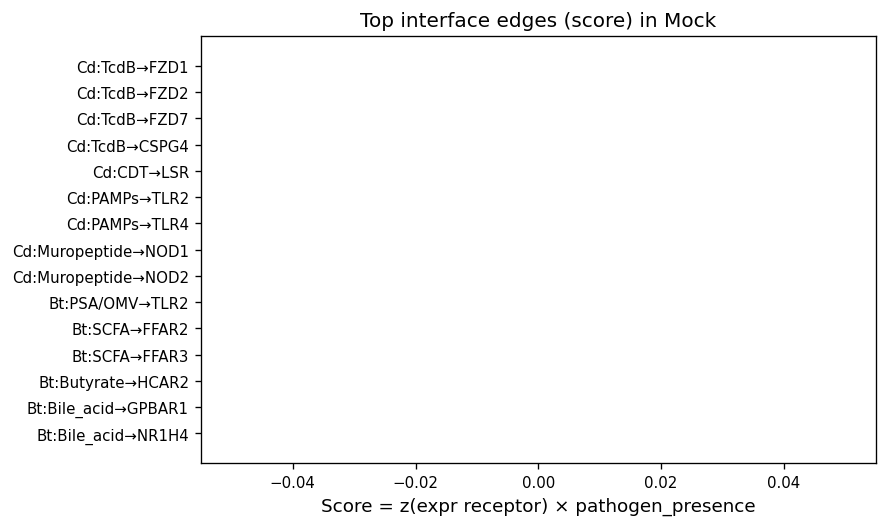

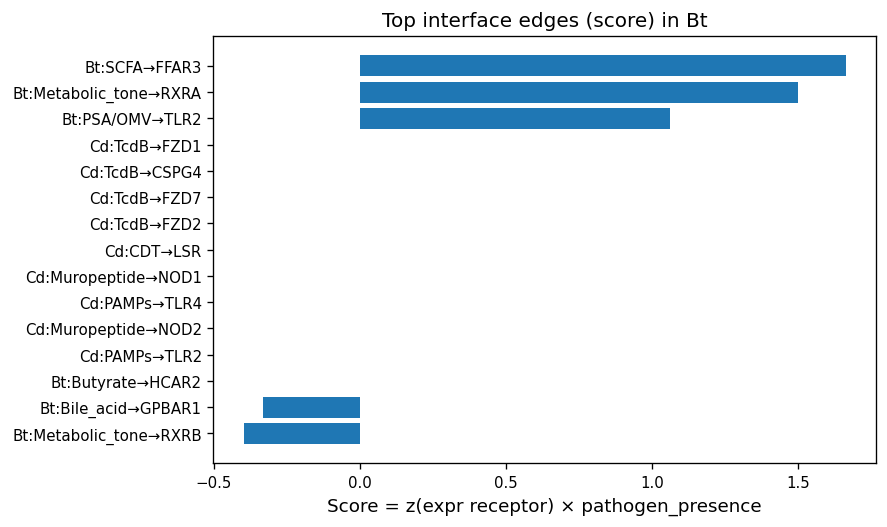

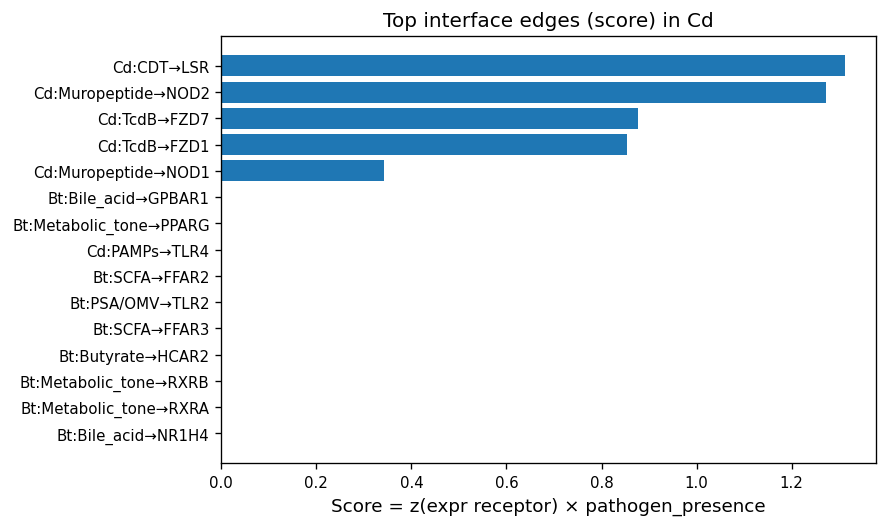

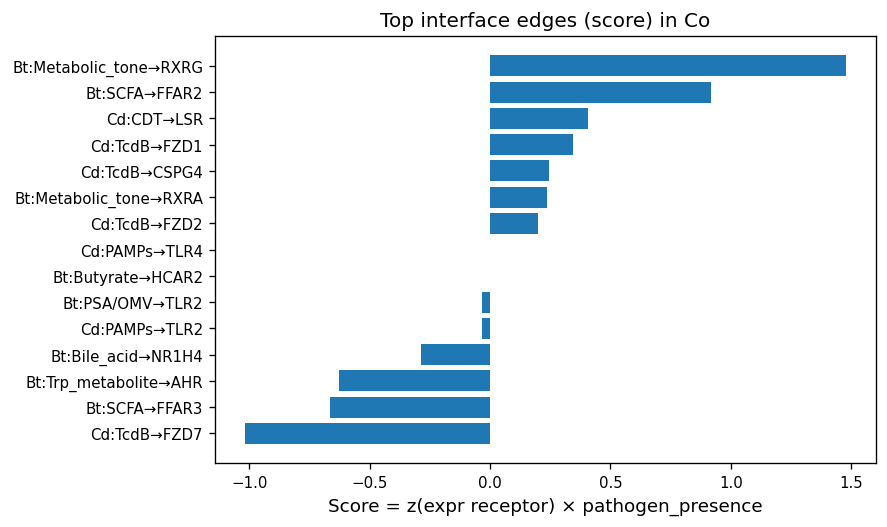

In [73]:
# ======================================
# 6) Sanity plots: top interface receptors per condition
# ======================================
plt.rcParams.update({"figure.dpi":120, "savefig.dpi":300})
for c in cond_cols:
    top = (edges.sort_values(f"score_{c}", ascending=False)
                 .head(15)
                 .copy())
    if top.empty: 
        continue
    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    ax.barh(
        [f"{r['pathogen']}:{r['ligand']}→{r['host_receptor']}" for _, r in top.iterrows()],
        top[f"score_{c}"].values
    )
    ax.invert_yaxis()
    ax.set_title(f"Top interface edges (score) in {c}")
    ax.set_xlabel("Score = z(expr receptor) × pathogen_presence")
    fig.tight_layout()
    fig.savefig(OUT/f"top_interface_edges_{c}.png", bbox_inches="tight", transparent=True)
    plt.show()


In [75]:
# ======================================
# 6) Table outputs: top interface receptors per condition
# ======================================
import pandas as pd

# edges: dataframe with columns like
# ['pathogen','ligand','host_receptor',
#  'host_expr_Mock','host_expr_Bt','host_expr_Cd','host_expr_Co',
#  'z_Mock','z_Bt','z_Cd','z_Co',
#  'score_Mock','score_Bt','score_Cd','score_Co']
# cond_cols: e.g. ["Mock","Bt","Cd","Co"]
# OUT: Path to output directory

N_TOP = 15

all_tables = []
for c in cond_cols:
    score_col = f"score_{c}"
    z_col     = f"z_{c}"
    expr_col  = f"host_expr_{c}"

    if score_col not in edges.columns:
        continue

    top = (edges
           .sort_values(score_col, ascending=False)
           .loc[:, ["pathogen","ligand","host_receptor", expr_col, z_col, score_col]]
           .head(N_TOP)
           .rename(columns={
               expr_col: "host_expr",
               z_col: "z",
               score_col: "score"
           })
           .copy())
    top.insert(0, "condition", c)

    # Save per-condition CSV
    top.to_csv(OUT / f"top_interface_edges_{c}.csv", index=False)

    # Pretty print to console/notebook
    print(f"\n=== Top {N_TOP} interface edges in {c} ===")
    print(top.to_string(index=False))

    all_tables.append(top)

# Also save a combined table across conditions
if all_tables:
    combined = pd.concat(all_tables, axis=0)
    combined.to_csv(OUT / "top_interface_edges_all_conditions.csv", index=False)

    # Optional: show first 30 combined rows
    print("\n=== Combined (first 30 rows) ===")
    print(combined.head(30).to_string(index=False))



=== Top 15 interface edges in Mock ===
condition pathogen      ligand host_receptor  host_expr         z  score
     Mock       Cd        TcdB          FZD1   3.561530  0.505260    0.0
     Mock       Cd        TcdB          FZD2   2.925367  1.380867    0.0
     Mock       Cd        TcdB          FZD7   7.071677  1.116479    0.0
     Mock       Cd        TcdB         CSPG4   8.622906  1.428205    0.0
     Mock       Cd         CDT           LSR  12.006021 -0.293971   -0.0
     Mock       Cd       PAMPs          TLR2   1.597730  0.570275    0.0
     Mock       Cd       PAMPs          TLR4   0.000000  0.000000    0.0
     Mock       Cd Muropeptide          NOD1   8.589539  1.333353    0.0
     Mock       Cd Muropeptide          NOD2   3.169925 -0.877642   -0.0
     Mock       Bt     PSA/OMV          TLR2   1.597730  0.570275    0.0
     Mock       Bt        SCFA         FFAR2   2.816941 -0.357054   -0.0
     Mock       Bt        SCFA         FFAR3   0.150560 -0.118323   -0.0
     Mock  

In [74]:
# ======================================
# 7) Optional: export host-side receptor availability table (for downstream)
# ======================================
host_receptors = sorted(set(edges["host_receptor"]) - {"(brush_border)"})
avail = sym_tab.reindex(host_receptors)
avail.to_csv(OUT/"host_receptor_expression_log2.csv")
avail.head(10)


condition,Mock,Bt,Cd,Co
gene_symbol,,,,
AHR,7.646139,7.382091,7.424446,7.394434
CSPG4,8.622906,8.004014,8.227792,8.358124
FFAR2,2.816941,2.462925,3.219814,3.218781
FFAR3,0.150560,0.502500,0.000000,0.042644
FZD1,3.561530,2.809414,3.679949,3.506737
FZD2,2.925367,2.185867,1.576925,2.358021
FZD7,7.071677,6.066663,6.956095,6.045487
GPBAR1,5.059182,3.779610,4.247928,3.017328
HCAR2,0.000000,0.000000,0.000000,0.000000
